In [1]:
# Standard packages
import os
import torch
import pickle
import random
import numpy as np
import pandas as pd
from modules.autoencoder import *
from sklearn.model_selection import KFold

from torch import nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset

In [ ]:
# Colab packages
from google.colab import files, drive

# Connect drive to colab
drive.mount('/content/drive')

# Create directories (Colab)
!mkdir ./dataset
!mkdir ./drive/My\ Drive/results
!mkdir ./drive/My\ Drive/results/losses

# Data loading and preprocessing

In [2]:
#%% Define paths

data_root_dir = './dataset'


#%% Create dataset

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)

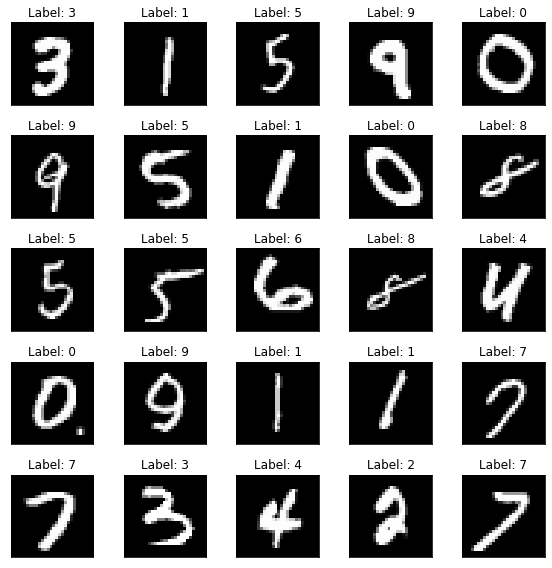

In [3]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Training

## Architecture definition

In [4]:
### Dimension of the batch
batch_size = 1000
### Number of epochs
num_epochs = 20
### Hidden layer dimension - TODO: tuning
encoded_space_dim = 4

### Initialize the network
net = Autoencoder(encoded_space_dim=encoded_space_dim)

In [5]:
### Some examples
# Take an input image (remember to add the batch dimension)
img = test_dataset[0][0].unsqueeze(0)
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encode(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decode(img_enc)
print('Decoded image shape:', dec_img.shape)

del img, img_enc, dec_img

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [6]:
#%% Prepare training

### Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define a loss function
loss_fn = torch.nn.MSELoss()

### Set devide
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('### Device: {} ###'.format(device), end = '\n\n')
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
print('### ARCHITECTURE ###')
net.to(device)

### Device: cpu ###

### ARCHITECTURE ###


Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvT

## Parameter optimization: GridSearch and CrossValidation

In [ ]:
%%time

indices = list(range(len(train_dataset)))

# learning rate cycle
for lr in [1e-2, 1e-3, 1e-4]:
    # weight decay cycle
    for decay in [1e-3, 1e-4, 1e-5]:
        print(f'### PARAMETERS: lr = {lr}, decay = {decay} ###')
        results = train_CV(indices, device, train_dataset, encoded_dim = encoded_space_dim, 
                                      lr = lr, wd = decay, num_epochs = num_epochs)
        # Save results
        with open(f'./drive/My Drive/results/losses/CV_loss_{encoded_space_dim}_{lr}_{decay}.pickle', 'wb') as f:
            pickle.dump(results, f)

### PARAMETERS: lr = 0.01, decay = 0.001 ###
+++ FOLD 0 +++
EPOCH 1/20
	 TRAINING - EPOCH 1/20 - loss: 0.094654
	 VALIDATION - EPOCH 1/20 - loss: 0.070204

EPOCH 2/20
	 TRAINING - EPOCH 2/20 - loss: 0.068374
	 VALIDATION - EPOCH 2/20 - loss: 0.067588

EPOCH 3/20
	 TRAINING - EPOCH 3/20 - loss: 0.067651
	 VALIDATION - EPOCH 3/20 - loss: 0.067576

EPOCH 4/20
	 TRAINING - EPOCH 4/20 - loss: 0.066437
	 VALIDATION - EPOCH 4/20 - loss: 0.065123

EPOCH 5/20
	 TRAINING - EPOCH 5/20 - loss: 0.064671
	 VALIDATION - EPOCH 5/20 - loss: 0.064055

EPOCH 6/20
	 TRAINING - EPOCH 6/20 - loss: 0.064277
	 VALIDATION - EPOCH 6/20 - loss: 0.064106

EPOCH 7/20
	 TRAINING - EPOCH 7/20 - loss: 0.064209
	 VALIDATION - EPOCH 7/20 - loss: 0.063919

EPOCH 8/20
	 TRAINING - EPOCH 8/20 - loss: 0.064172
	 VALIDATION - EPOCH 8/20 - loss: 0.063878

EPOCH 9/20
	 TRAINING - EPOCH 9/20 - loss: 0.064195
	 VALIDATION - EPOCH 9/20 - loss: 0.063894

EPOCH 10/20
	 TRAINING - EPOCH 10/20 - loss: 0.064065
	 VALIDATION - EPOCH 1

## Results Visualization

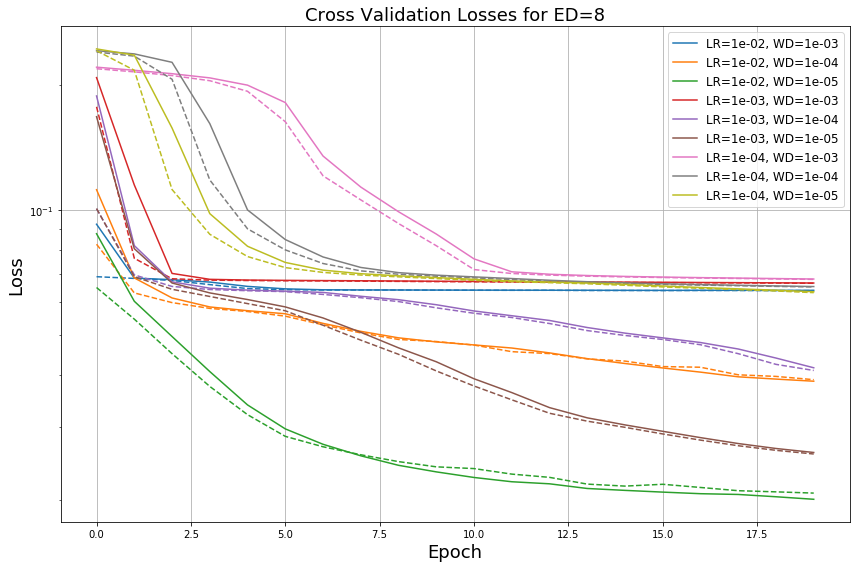

In [24]:
# Set dimension of interest
encoded_space_dim = 8

# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))
cmap = plt.get_cmap("tab10")

i = 0
# learning rate cycle
for lr in [1e-2, 1e-3, 1e-4]:
    # weight decay cycle
    for decay in [1e-3, 1e-4, 1e-5]:
        # retrive data
        with open(f'results/losses/CV_loss_{encoded_space_dim}_{lr}_{decay}.pickle','rb') as f:
            results = pickle.load(f)
        # plot data
        plt.semilogy(results['train loss'], 
                    label='LR={:1.0e}, WD={:1.0e}'.format(lr,decay),
                    color = cmap(i))
        plt.semilogy(results['validation loss'], 
                    #label='Validation loss mean fold LR={:1.0e}, WD={:1.0e}'.format(lr,decay),
                    linestyle='dashed',
                    color = cmap(i))
        i += 1


plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title(f'Cross Validation Losses for ED={encoded_space_dim}', fontsize=18)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f"images/CV_losses_{encoded_space_dim}.png")
#files.download(f"CV_losses_{encoded_space_dim}.png")
plt.show()

## Training with optimized parameters

EPOCH 1/100

	 TRAINING - EPOCH 1/100 - loss: 0.087231

	 VALIDATION - EPOCH 1/100 - loss: 0.063316




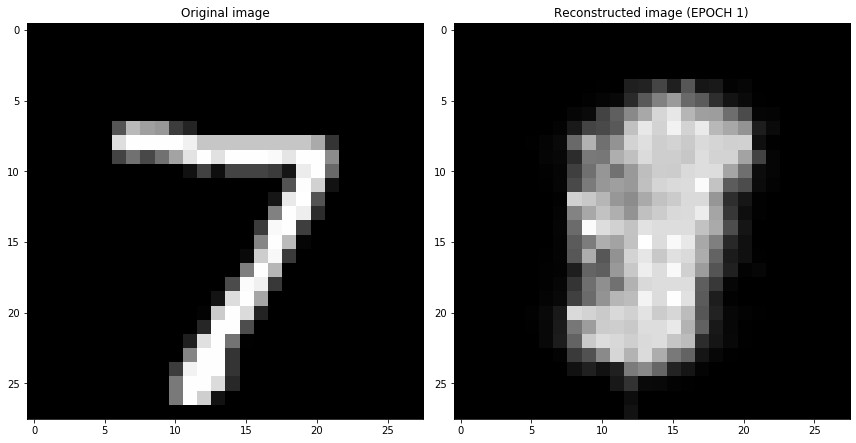

<Figure size 432x288 with 0 Axes>

EPOCH 2/100

	 TRAINING - EPOCH 2/100 - loss: 0.056500

	 VALIDATION - EPOCH 2/100 - loss: 0.051671




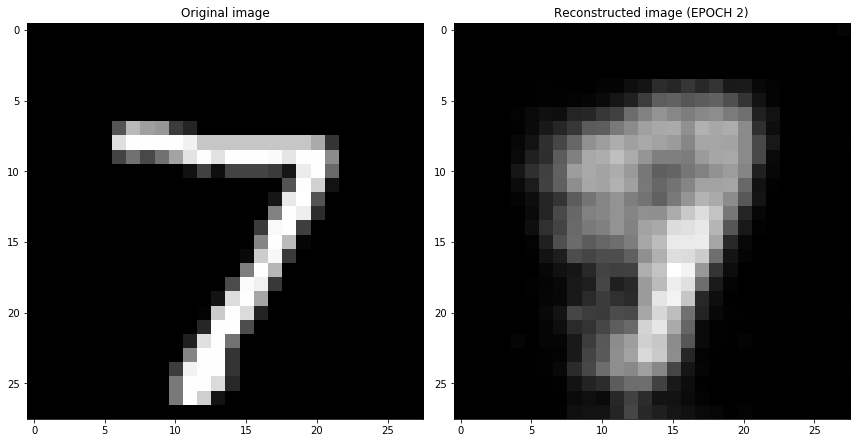

<Figure size 432x288 with 0 Axes>

EPOCH 3/100

	 TRAINING - EPOCH 3/100 - loss: 0.043242

	 VALIDATION - EPOCH 3/100 - loss: 0.039104




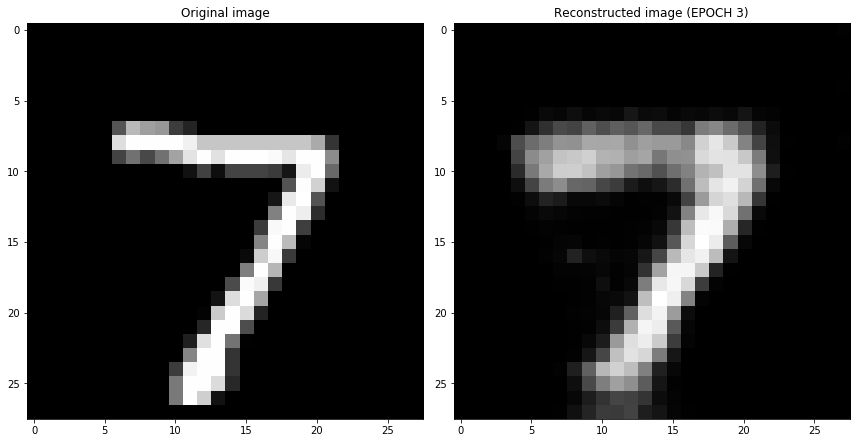

<Figure size 432x288 with 0 Axes>

EPOCH 4/100

	 TRAINING - EPOCH 4/100 - loss: 0.037246

	 VALIDATION - EPOCH 4/100 - loss: 0.035497




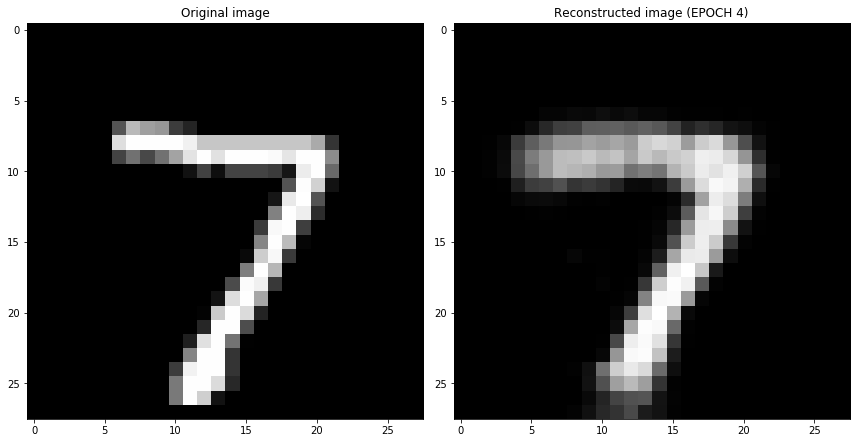

<Figure size 432x288 with 0 Axes>

EPOCH 5/100

	 TRAINING - EPOCH 5/100 - loss: 0.034961

	 VALIDATION - EPOCH 5/100 - loss: 0.033891




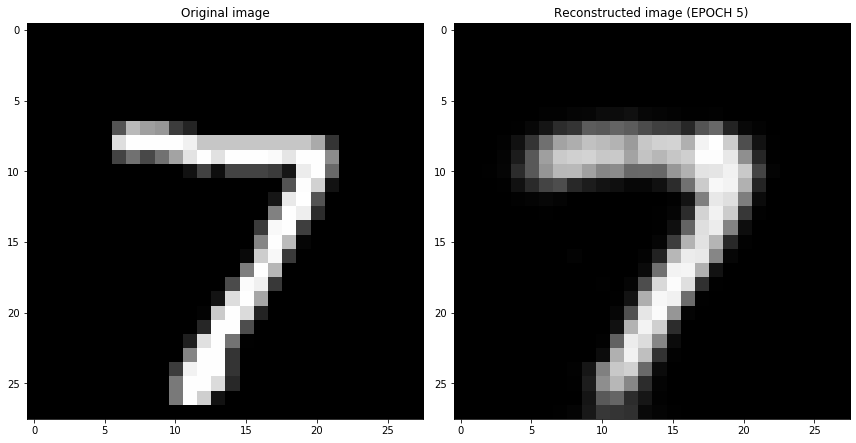

<Figure size 432x288 with 0 Axes>

EPOCH 6/100

	 TRAINING - EPOCH 6/100 - loss: 0.033947

	 VALIDATION - EPOCH 6/100 - loss: 0.033211




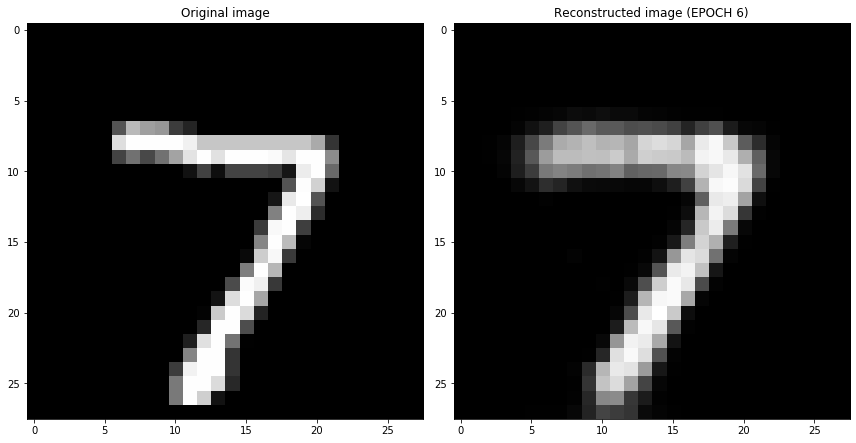

<Figure size 432x288 with 0 Axes>

EPOCH 7/100

	 TRAINING - EPOCH 7/100 - loss: 0.032931

	 VALIDATION - EPOCH 7/100 - loss: 0.032312




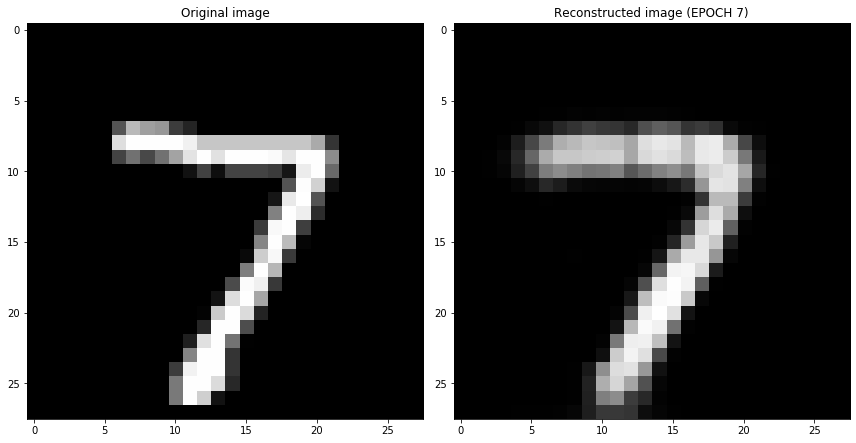

<Figure size 432x288 with 0 Axes>

EPOCH 8/100

	 TRAINING - EPOCH 8/100 - loss: 0.032303

	 VALIDATION - EPOCH 8/100 - loss: 0.032706




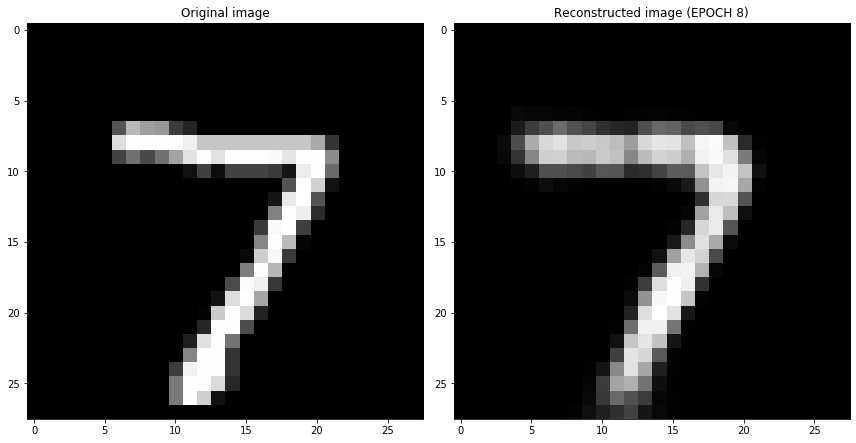

<Figure size 432x288 with 0 Axes>

EPOCH 9/100

	 TRAINING - EPOCH 9/100 - loss: 0.032288

	 VALIDATION - EPOCH 9/100 - loss: 0.032308




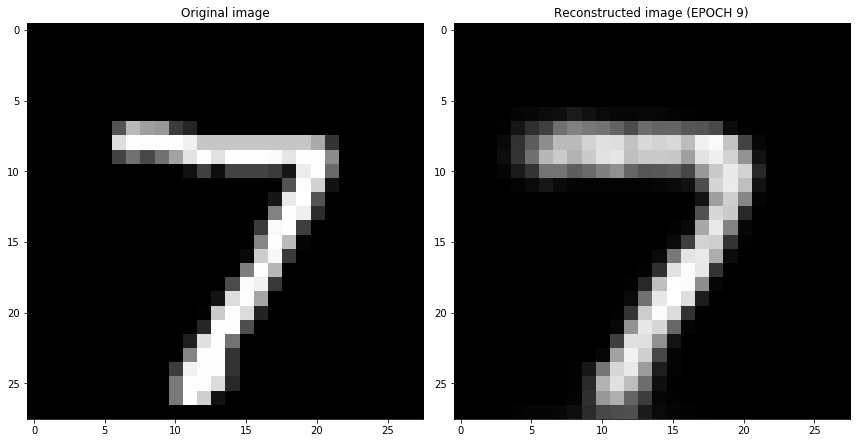

<Figure size 432x288 with 0 Axes>

EPOCH 10/100

	 TRAINING - EPOCH 10/100 - loss: 0.031531

	 VALIDATION - EPOCH 10/100 - loss: 0.031325




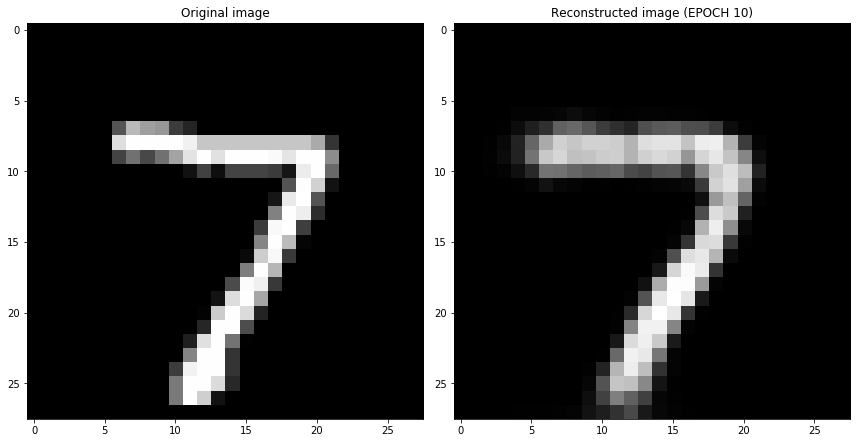

<Figure size 432x288 with 0 Axes>

EPOCH 11/100

	 TRAINING - EPOCH 11/100 - loss: 0.031085

	 VALIDATION - EPOCH 11/100 - loss: 0.031344




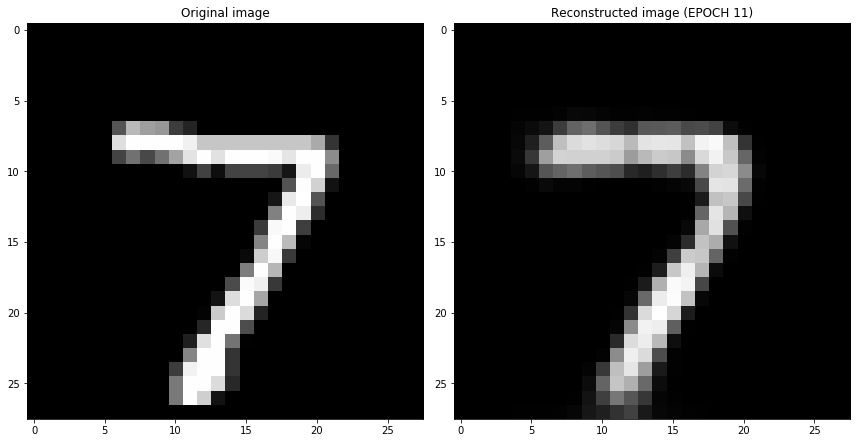

<Figure size 432x288 with 0 Axes>

EPOCH 12/100

	 TRAINING - EPOCH 12/100 - loss: 0.030868

	 VALIDATION - EPOCH 12/100 - loss: 0.031037




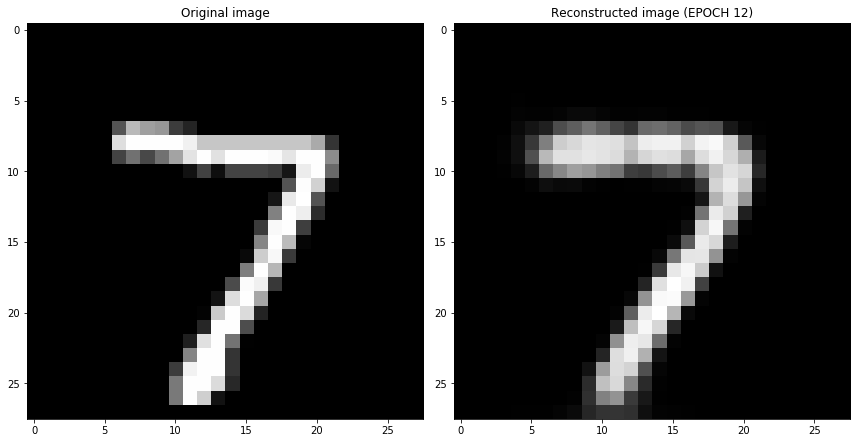

<Figure size 432x288 with 0 Axes>

EPOCH 13/100

	 TRAINING - EPOCH 13/100 - loss: 0.030513

	 VALIDATION - EPOCH 13/100 - loss: 0.030215




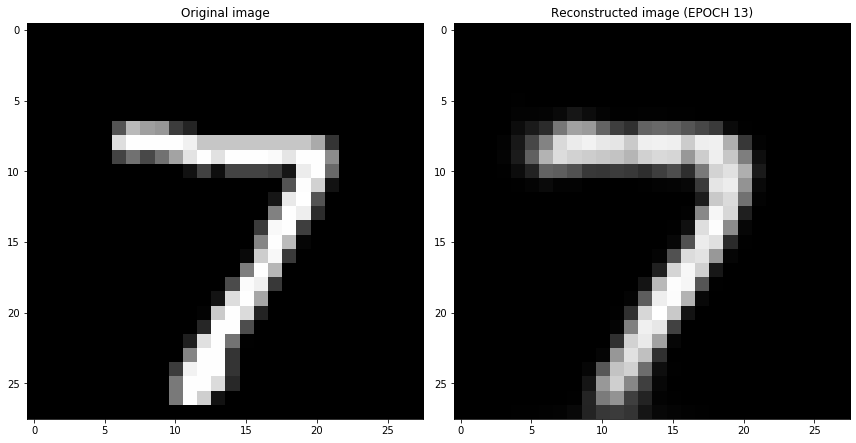

<Figure size 432x288 with 0 Axes>

EPOCH 14/100

	 TRAINING - EPOCH 14/100 - loss: 0.030458

	 VALIDATION - EPOCH 14/100 - loss: 0.030240




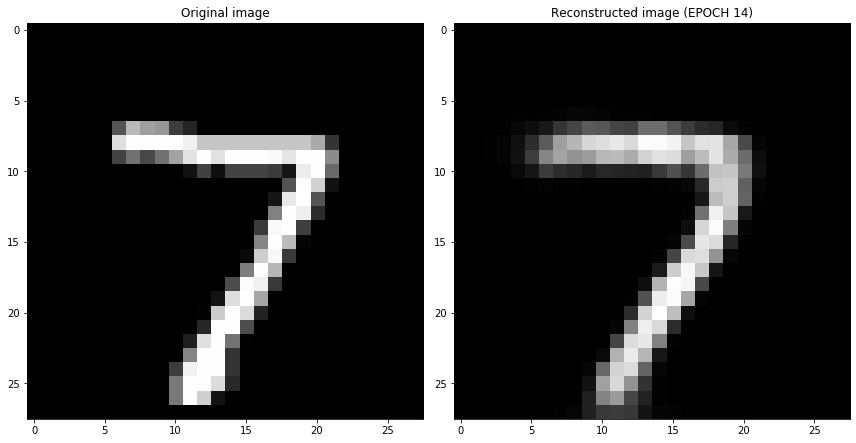

<Figure size 432x288 with 0 Axes>

EPOCH 15/100

	 TRAINING - EPOCH 15/100 - loss: 0.030174

	 VALIDATION - EPOCH 15/100 - loss: 0.030144




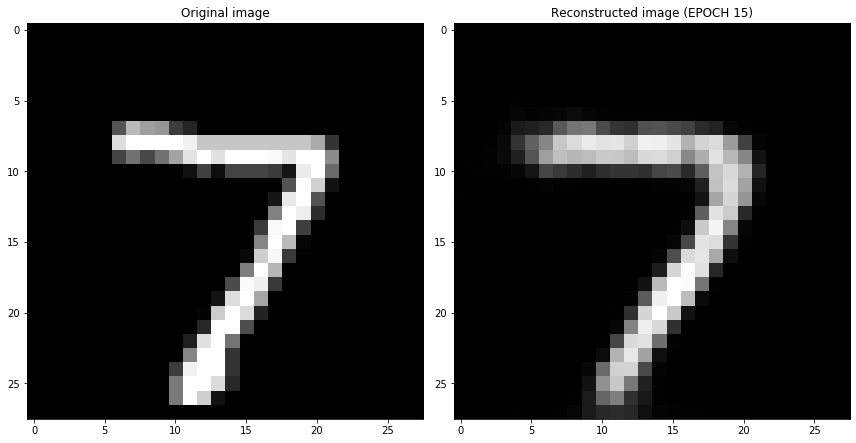

<Figure size 432x288 with 0 Axes>

EPOCH 16/100

	 TRAINING - EPOCH 16/100 - loss: 0.029946

	 VALIDATION - EPOCH 16/100 - loss: 0.029892




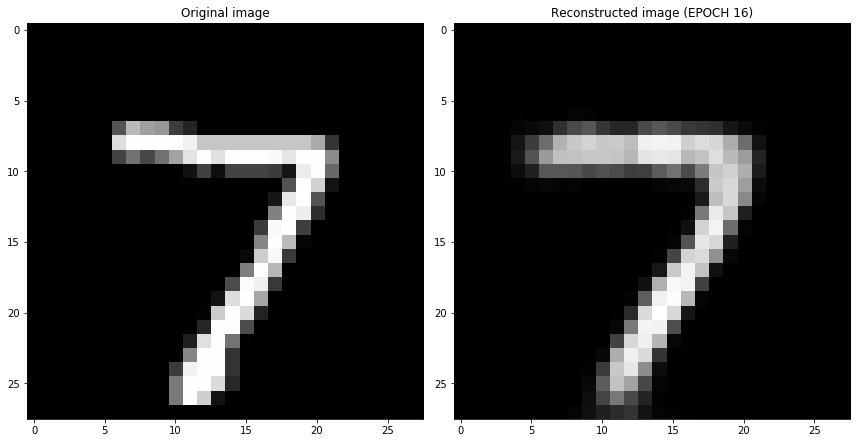

<Figure size 432x288 with 0 Axes>

EPOCH 17/100

	 TRAINING - EPOCH 17/100 - loss: 0.029933

	 VALIDATION - EPOCH 17/100 - loss: 0.029772




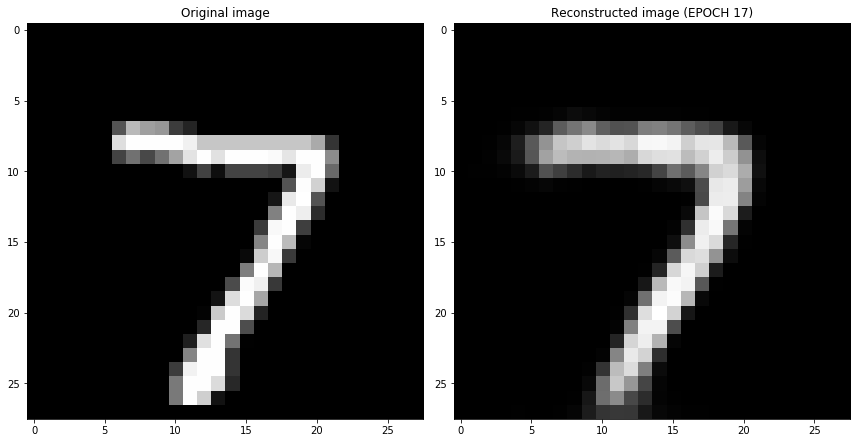

<Figure size 432x288 with 0 Axes>

EPOCH 18/100

	 TRAINING - EPOCH 18/100 - loss: 0.029854

	 VALIDATION - EPOCH 18/100 - loss: 0.029638




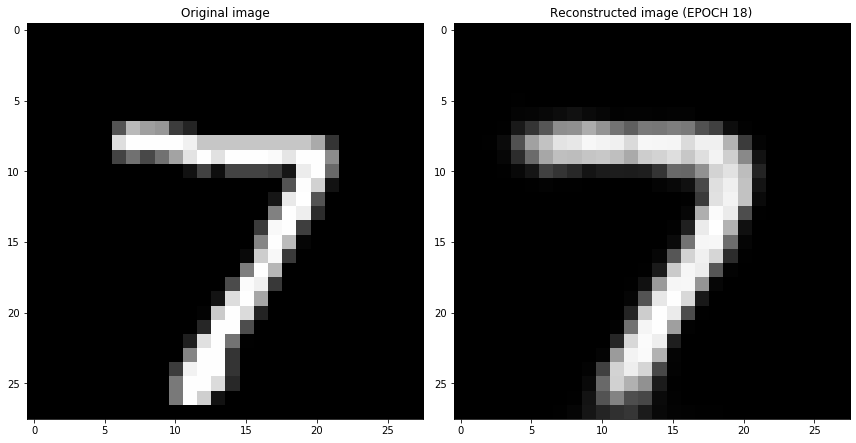

<Figure size 432x288 with 0 Axes>

EPOCH 19/100

	 TRAINING - EPOCH 19/100 - loss: 0.030386

	 VALIDATION - EPOCH 19/100 - loss: 0.032934




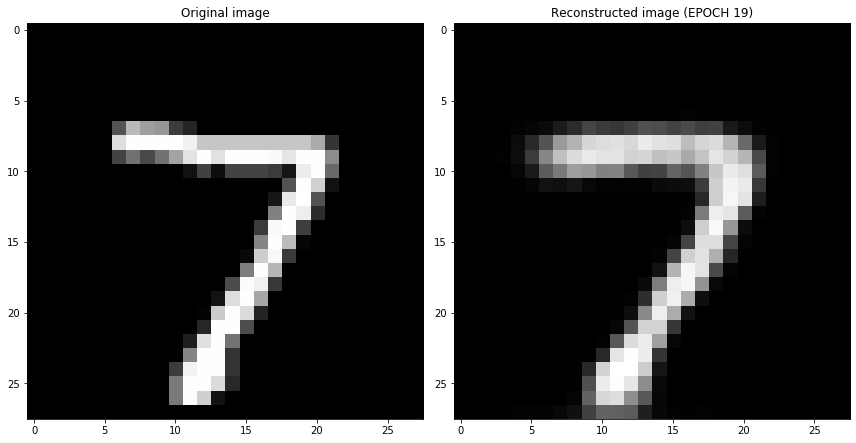

<Figure size 432x288 with 0 Axes>

EPOCH 20/100

	 TRAINING - EPOCH 20/100 - loss: 0.030306

	 VALIDATION - EPOCH 20/100 - loss: 0.029421




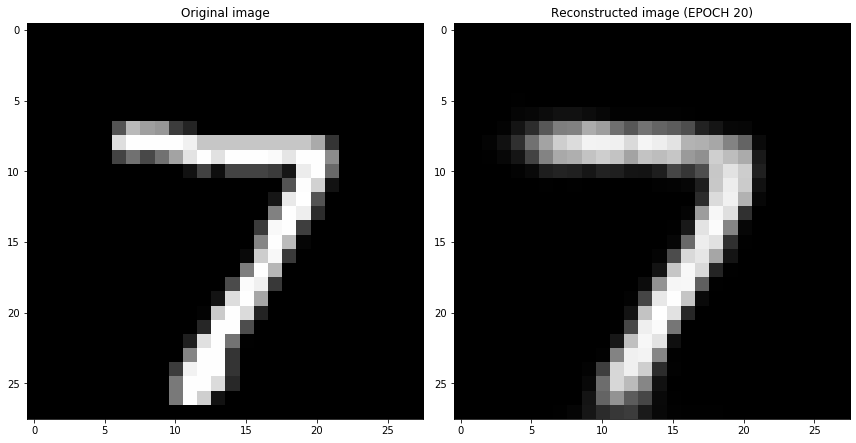

<Figure size 432x288 with 0 Axes>

EPOCH 21/100

	 TRAINING - EPOCH 21/100 - loss: 0.029272

	 VALIDATION - EPOCH 21/100 - loss: 0.029340




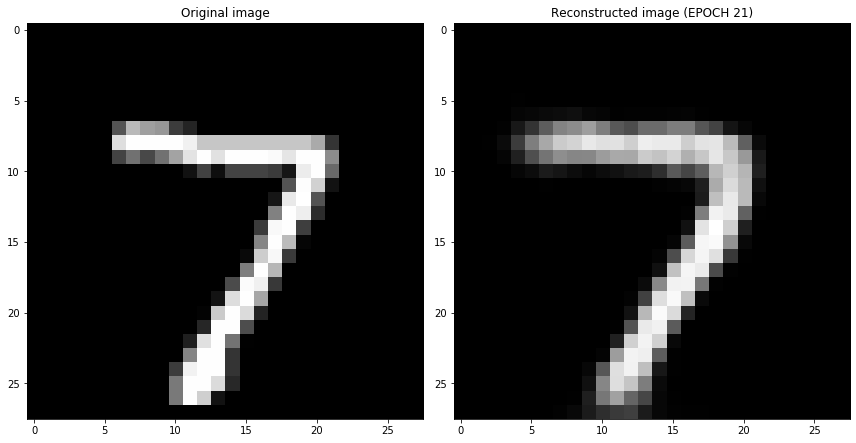

<Figure size 432x288 with 0 Axes>

EPOCH 22/100

	 TRAINING - EPOCH 22/100 - loss: 0.029258

	 VALIDATION - EPOCH 22/100 - loss: 0.029175




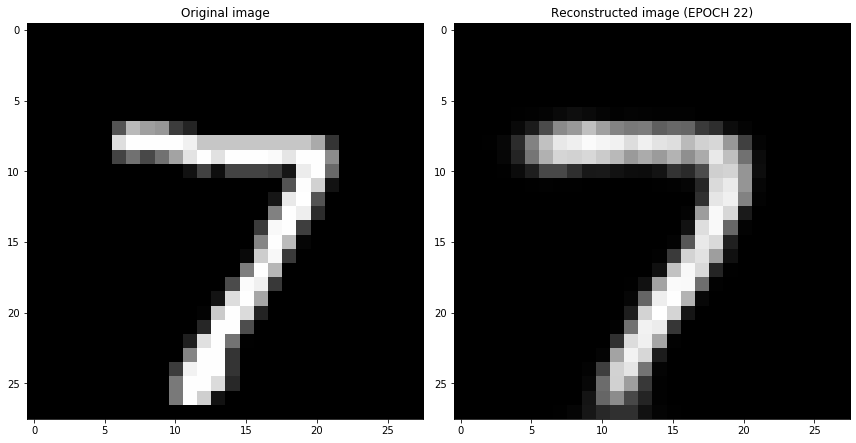

<Figure size 432x288 with 0 Axes>

EPOCH 23/100

	 TRAINING - EPOCH 23/100 - loss: 0.029071

	 VALIDATION - EPOCH 23/100 - loss: 0.029339




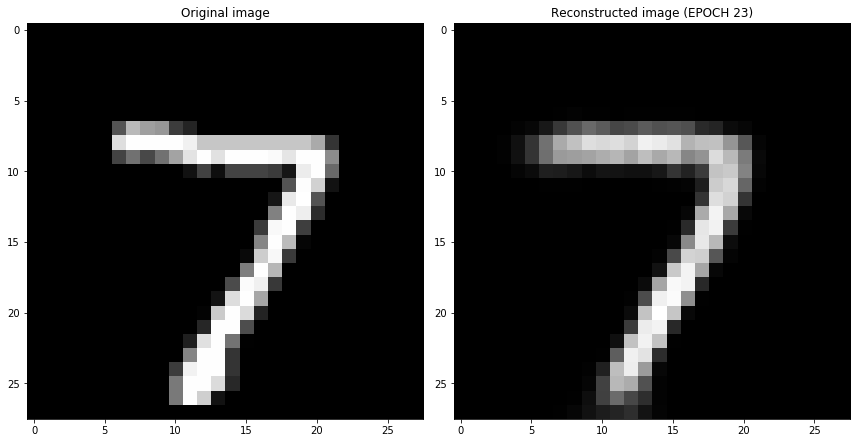

<Figure size 432x288 with 0 Axes>

EPOCH 24/100

	 TRAINING - EPOCH 24/100 - loss: 0.029108

	 VALIDATION - EPOCH 24/100 - loss: 0.029333




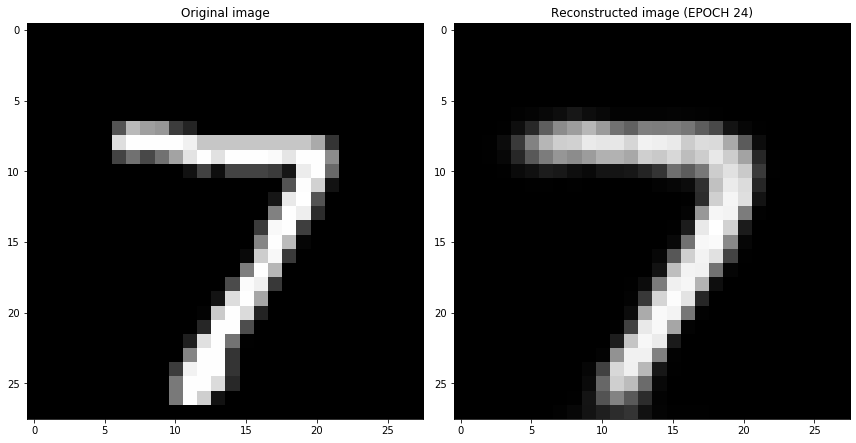

<Figure size 432x288 with 0 Axes>

EPOCH 25/100

	 TRAINING - EPOCH 25/100 - loss: 0.028942

	 VALIDATION - EPOCH 25/100 - loss: 0.028866




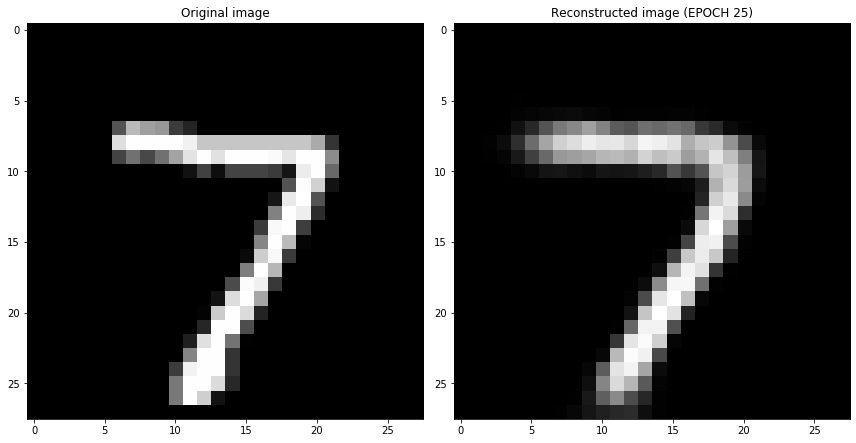

<Figure size 432x288 with 0 Axes>

EPOCH 26/100

	 TRAINING - EPOCH 26/100 - loss: 0.029017

	 VALIDATION - EPOCH 26/100 - loss: 0.029380




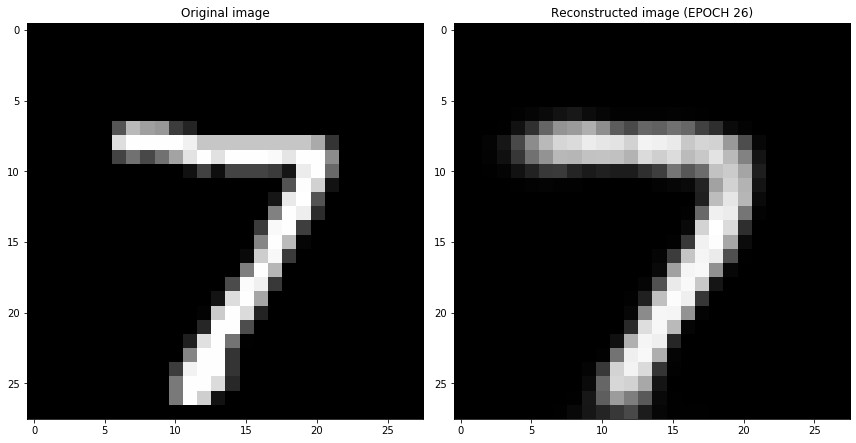

<Figure size 432x288 with 0 Axes>

EPOCH 27/100

	 TRAINING - EPOCH 27/100 - loss: 0.028793

	 VALIDATION - EPOCH 27/100 - loss: 0.029282




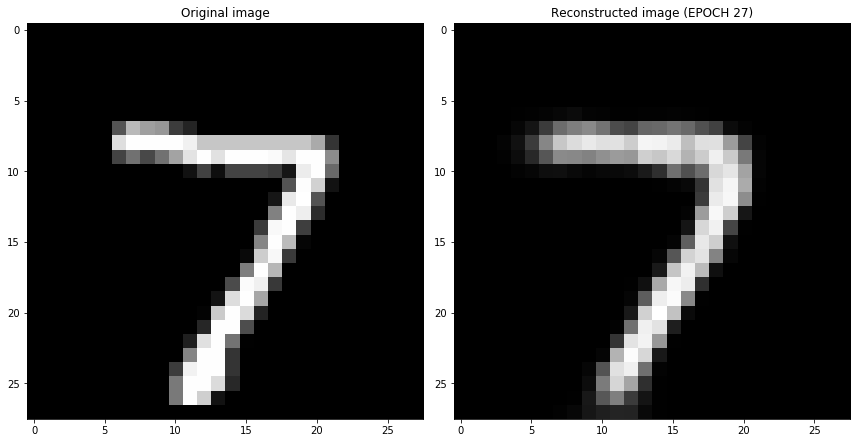

<Figure size 432x288 with 0 Axes>

EPOCH 28/100

	 TRAINING - EPOCH 28/100 - loss: 0.028896

	 VALIDATION - EPOCH 28/100 - loss: 0.028737




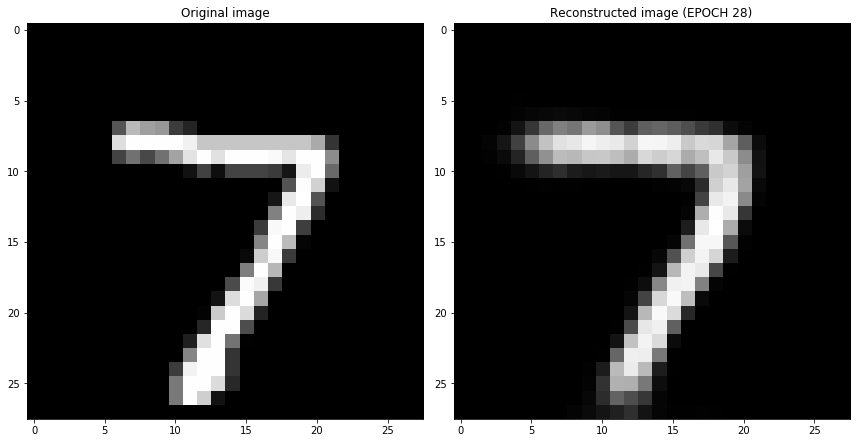

<Figure size 432x288 with 0 Axes>

EPOCH 29/100

	 TRAINING - EPOCH 29/100 - loss: 0.028714

	 VALIDATION - EPOCH 29/100 - loss: 0.028711




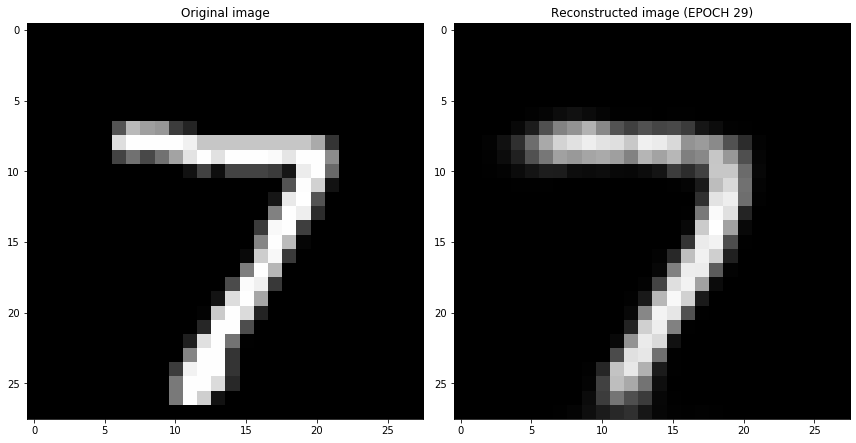

<Figure size 432x288 with 0 Axes>

EPOCH 30/100

	 TRAINING - EPOCH 30/100 - loss: 0.028539

	 VALIDATION - EPOCH 30/100 - loss: 0.028486




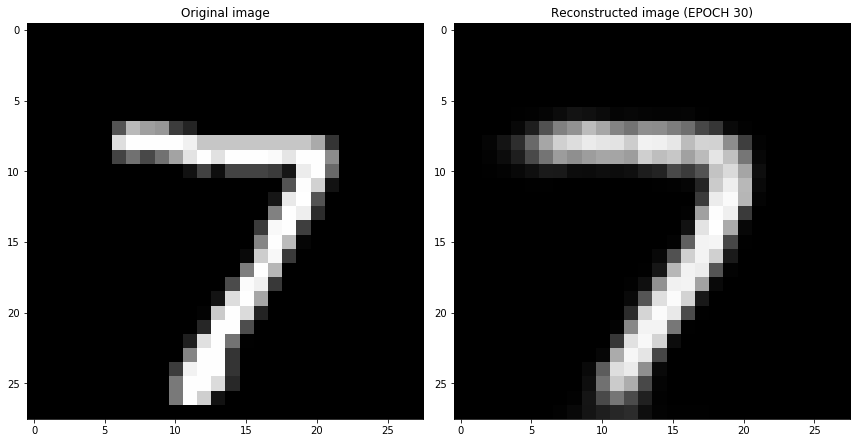

<Figure size 432x288 with 0 Axes>

EPOCH 31/100

	 TRAINING - EPOCH 31/100 - loss: 0.028515

	 VALIDATION - EPOCH 31/100 - loss: 0.028524




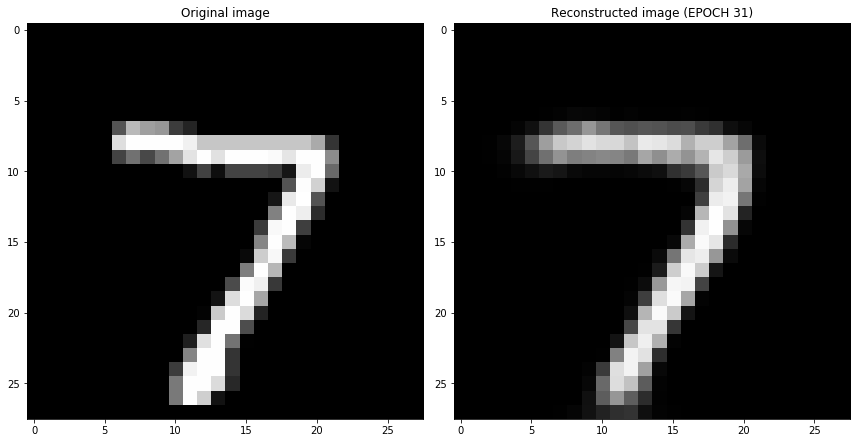

<Figure size 432x288 with 0 Axes>

EPOCH 32/100

	 TRAINING - EPOCH 32/100 - loss: 0.028499

	 VALIDATION - EPOCH 32/100 - loss: 0.028284




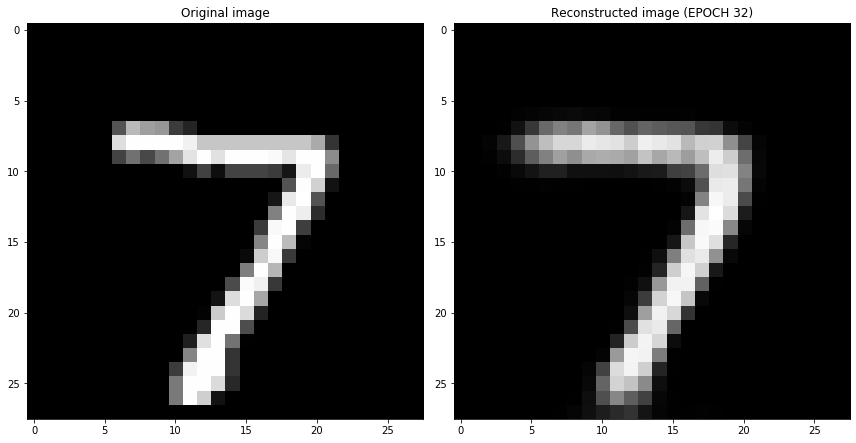

<Figure size 432x288 with 0 Axes>

EPOCH 33/100

	 TRAINING - EPOCH 33/100 - loss: 0.028422

	 VALIDATION - EPOCH 33/100 - loss: 0.028617




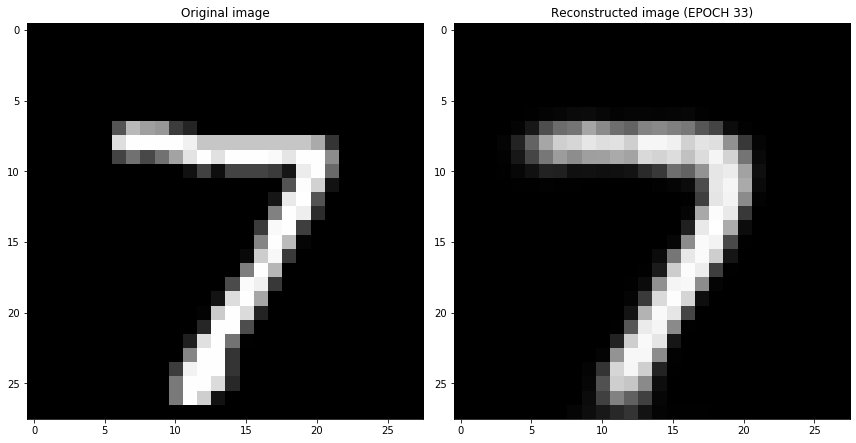

<Figure size 432x288 with 0 Axes>

EPOCH 34/100

	 TRAINING - EPOCH 34/100 - loss: 0.028400

	 VALIDATION - EPOCH 34/100 - loss: 0.028441




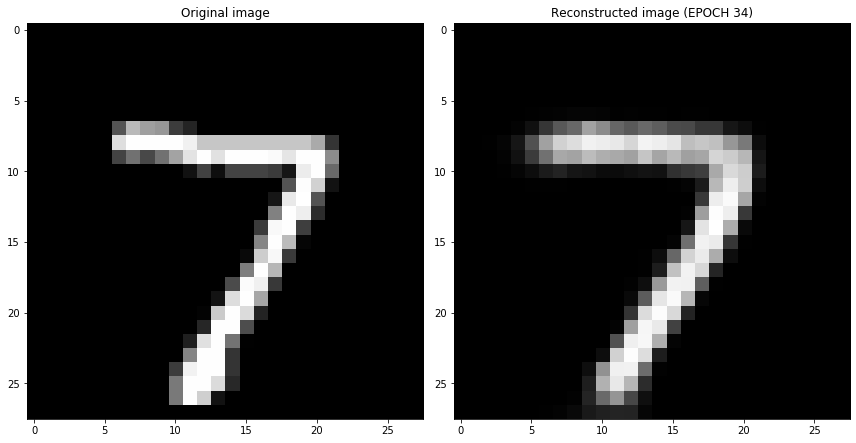

<Figure size 432x288 with 0 Axes>

EPOCH 35/100

	 TRAINING - EPOCH 35/100 - loss: 0.028541

	 VALIDATION - EPOCH 35/100 - loss: 0.028316




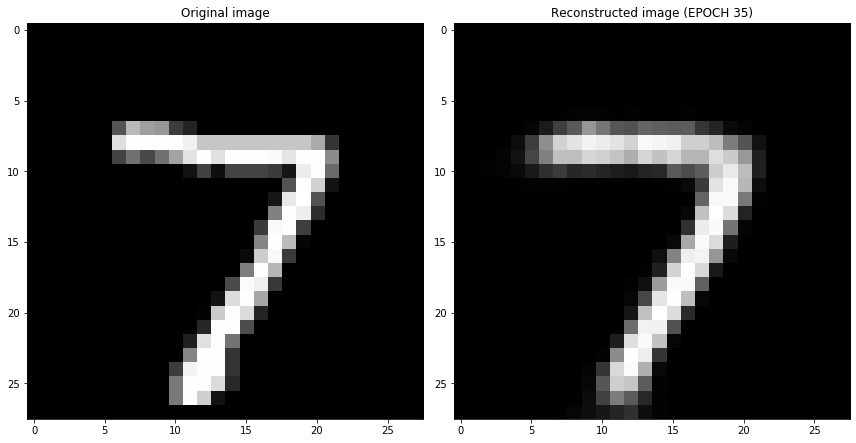

<Figure size 432x288 with 0 Axes>

EPOCH 36/100

	 TRAINING - EPOCH 36/100 - loss: 0.028307

	 VALIDATION - EPOCH 36/100 - loss: 0.028290




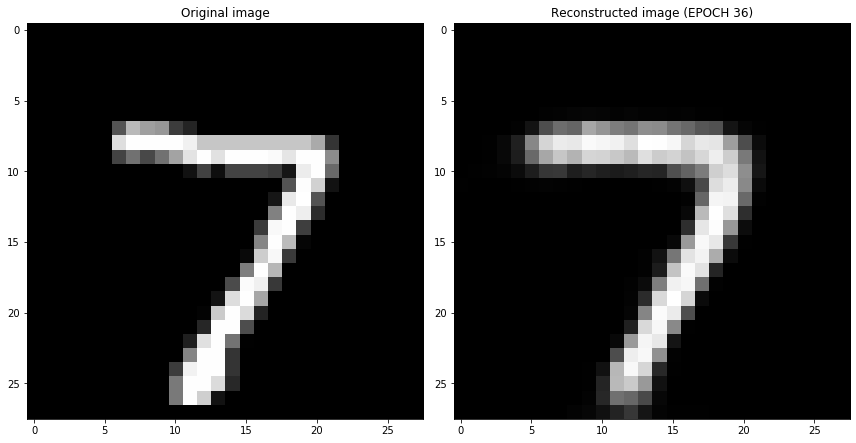

<Figure size 432x288 with 0 Axes>

EPOCH 37/100

	 TRAINING - EPOCH 37/100 - loss: 0.028196

	 VALIDATION - EPOCH 37/100 - loss: 0.028341




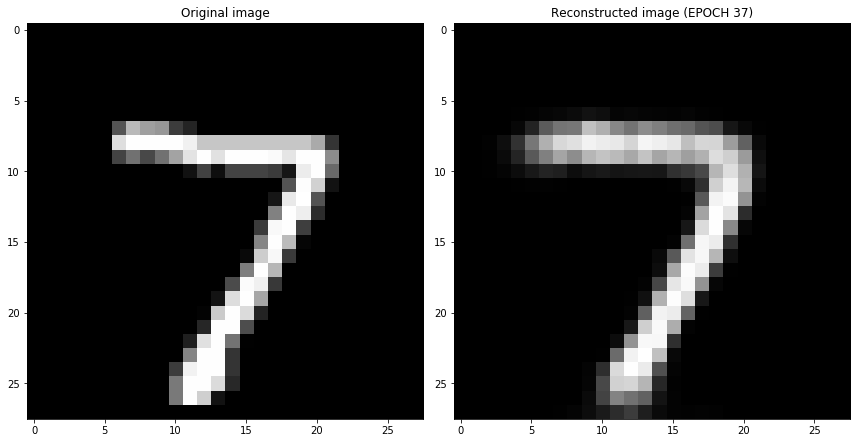

<Figure size 432x288 with 0 Axes>

EPOCH 38/100

	 TRAINING - EPOCH 38/100 - loss: 0.028330

	 VALIDATION - EPOCH 38/100 - loss: 0.028544




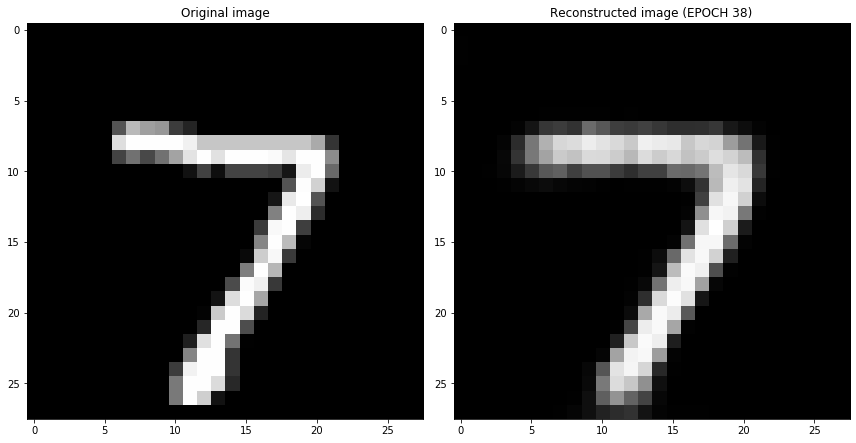

<Figure size 432x288 with 0 Axes>

EPOCH 39/100

	 TRAINING - EPOCH 39/100 - loss: 0.028053

	 VALIDATION - EPOCH 39/100 - loss: 0.028189




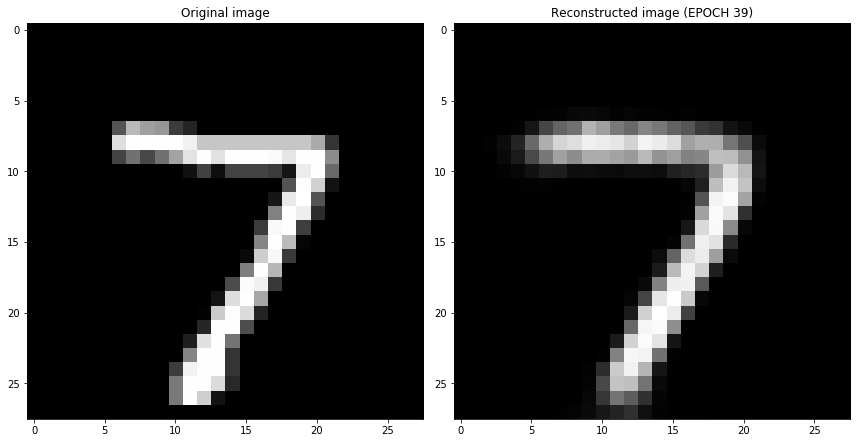

<Figure size 432x288 with 0 Axes>

EPOCH 40/100

	 TRAINING - EPOCH 40/100 - loss: 0.028191

	 VALIDATION - EPOCH 40/100 - loss: 0.028191




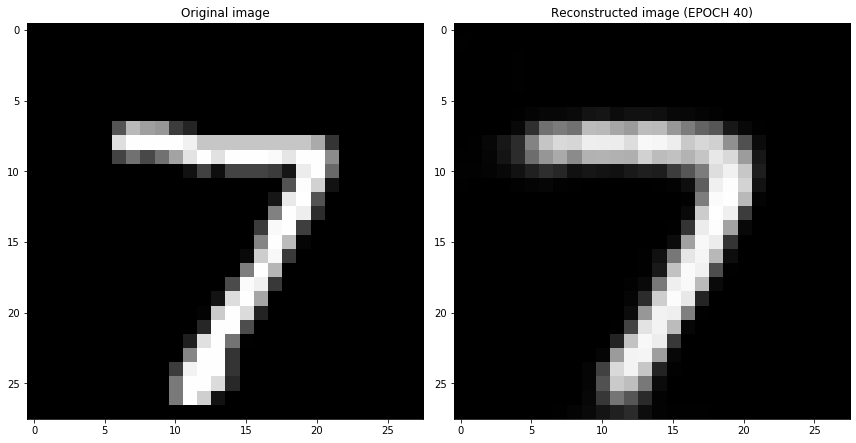

<Figure size 432x288 with 0 Axes>

EPOCH 41/100

	 TRAINING - EPOCH 41/100 - loss: 0.028022

	 VALIDATION - EPOCH 41/100 - loss: 0.028202




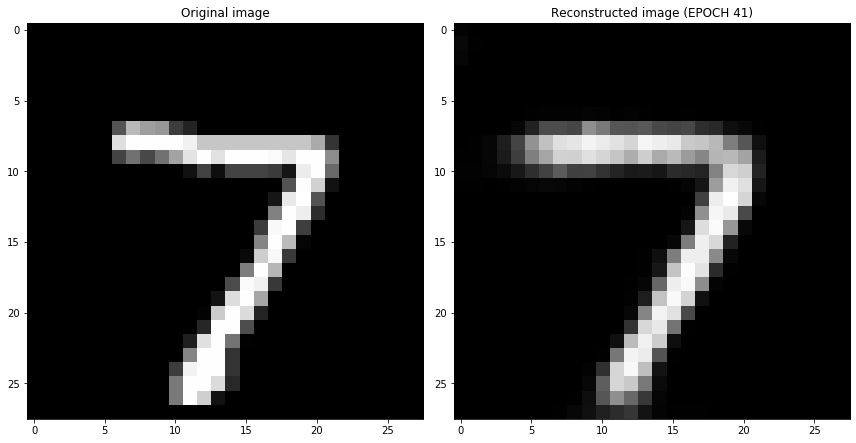

<Figure size 432x288 with 0 Axes>

EPOCH 42/100

	 TRAINING - EPOCH 42/100 - loss: 0.028021

	 VALIDATION - EPOCH 42/100 - loss: 0.028238




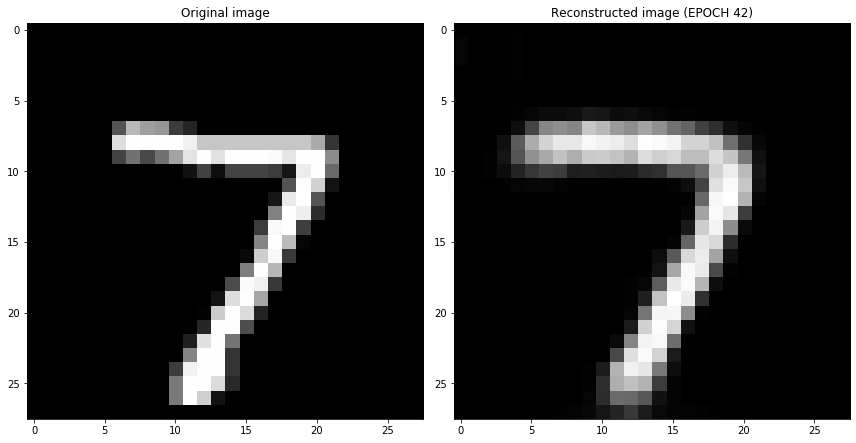

<Figure size 432x288 with 0 Axes>

EPOCH 43/100

	 TRAINING - EPOCH 43/100 - loss: 0.028007

	 VALIDATION - EPOCH 43/100 - loss: 0.028234




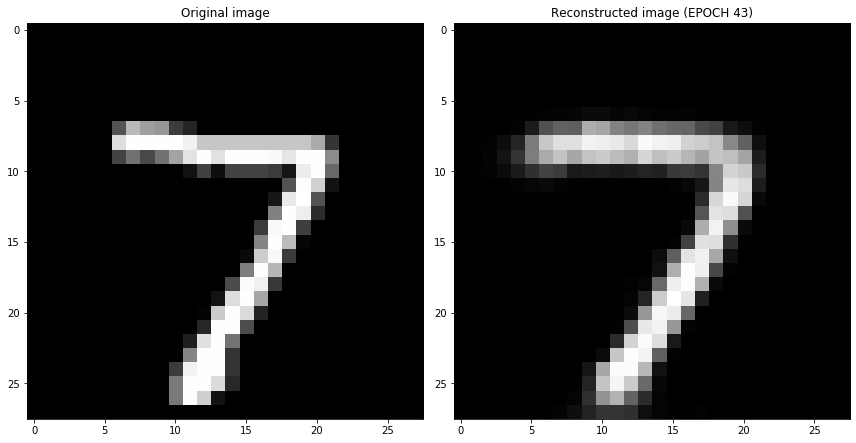

<Figure size 432x288 with 0 Axes>

EPOCH 44/100

	 TRAINING - EPOCH 44/100 - loss: 0.027949

	 VALIDATION - EPOCH 44/100 - loss: 0.027932




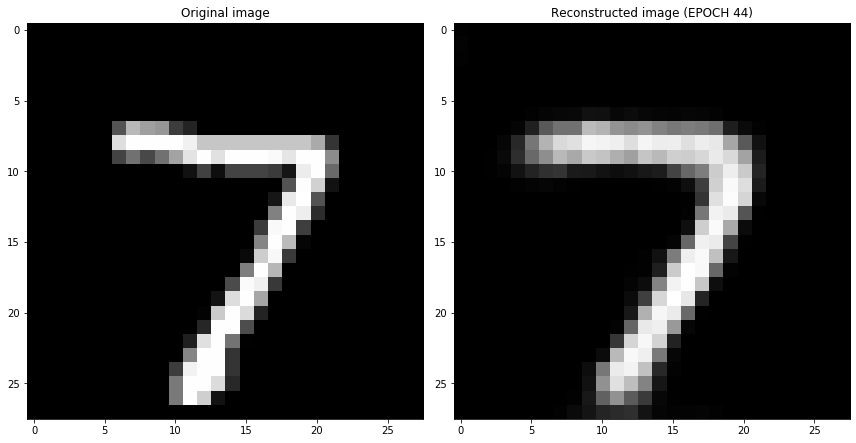

<Figure size 432x288 with 0 Axes>

EPOCH 45/100

	 TRAINING - EPOCH 45/100 - loss: 0.028479

	 VALIDATION - EPOCH 45/100 - loss: 0.028190




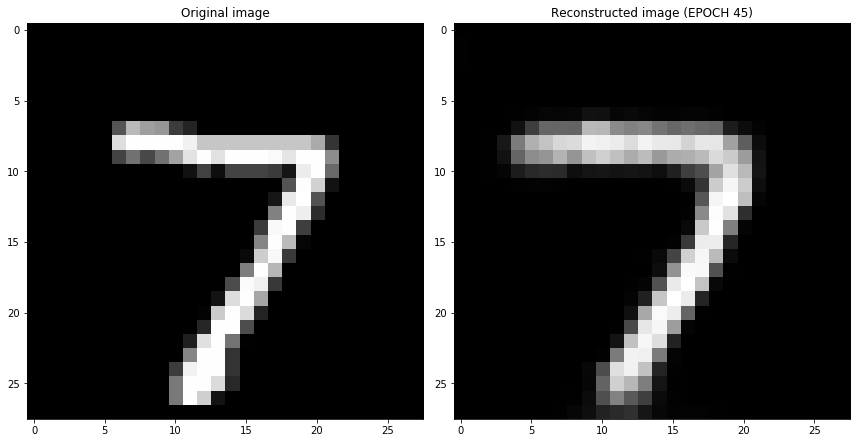

<Figure size 432x288 with 0 Axes>

EPOCH 46/100

	 TRAINING - EPOCH 46/100 - loss: 0.027877

	 VALIDATION - EPOCH 46/100 - loss: 0.028152




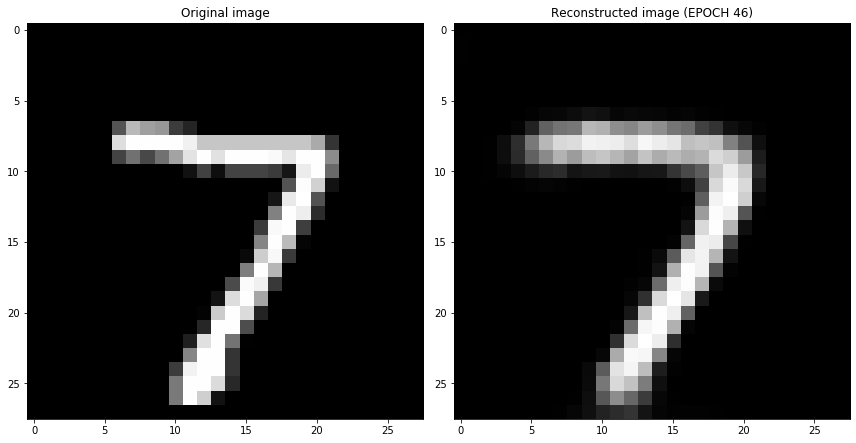

<Figure size 432x288 with 0 Axes>

EPOCH 47/100

	 TRAINING - EPOCH 47/100 - loss: 0.027825

	 VALIDATION - EPOCH 47/100 - loss: 0.027892




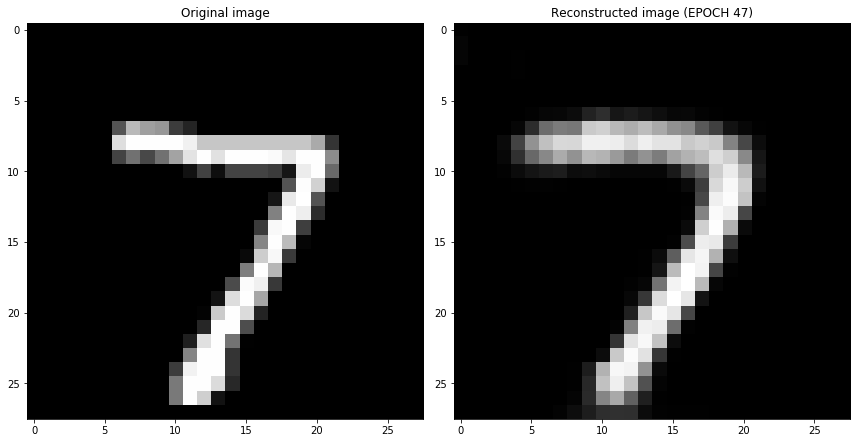

<Figure size 432x288 with 0 Axes>

EPOCH 48/100

	 TRAINING - EPOCH 48/100 - loss: 0.027737

	 VALIDATION - EPOCH 48/100 - loss: 0.027804




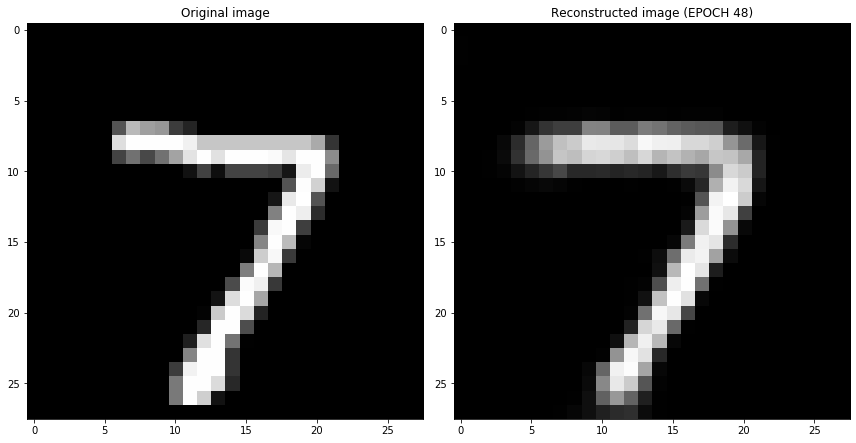

<Figure size 432x288 with 0 Axes>

EPOCH 49/100

	 TRAINING - EPOCH 49/100 - loss: 0.027774

	 VALIDATION - EPOCH 49/100 - loss: 0.027908




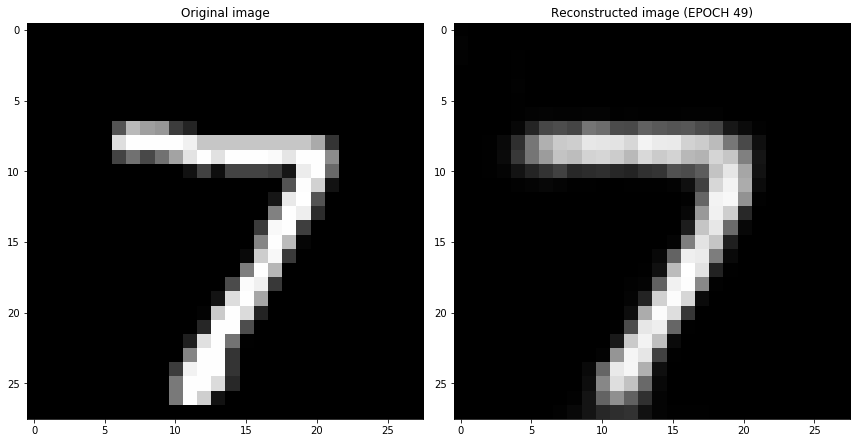

<Figure size 432x288 with 0 Axes>

EPOCH 50/100

	 TRAINING - EPOCH 50/100 - loss: 0.027816

	 VALIDATION - EPOCH 50/100 - loss: 0.028477




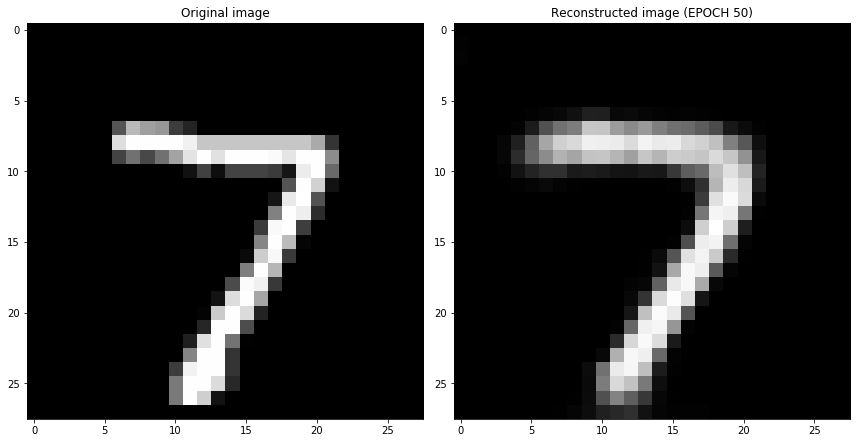

<Figure size 432x288 with 0 Axes>

EPOCH 51/100

	 TRAINING - EPOCH 51/100 - loss: 0.027776

	 VALIDATION - EPOCH 51/100 - loss: 0.027962




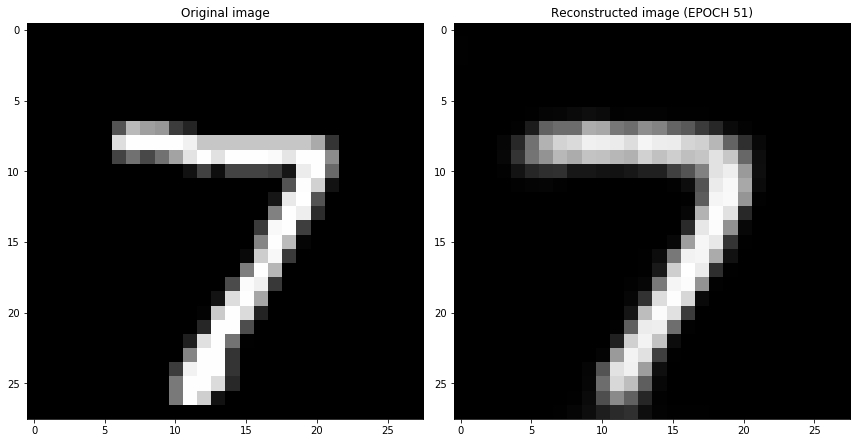

<Figure size 432x288 with 0 Axes>

EPOCH 52/100

	 TRAINING - EPOCH 52/100 - loss: 0.027752

	 VALIDATION - EPOCH 52/100 - loss: 0.027865




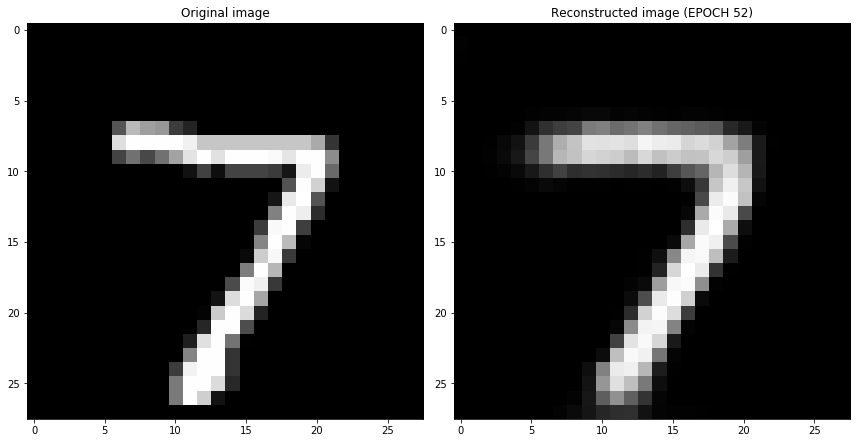

<Figure size 432x288 with 0 Axes>

EPOCH 53/100

	 TRAINING - EPOCH 53/100 - loss: 0.027632

	 VALIDATION - EPOCH 53/100 - loss: 0.027860




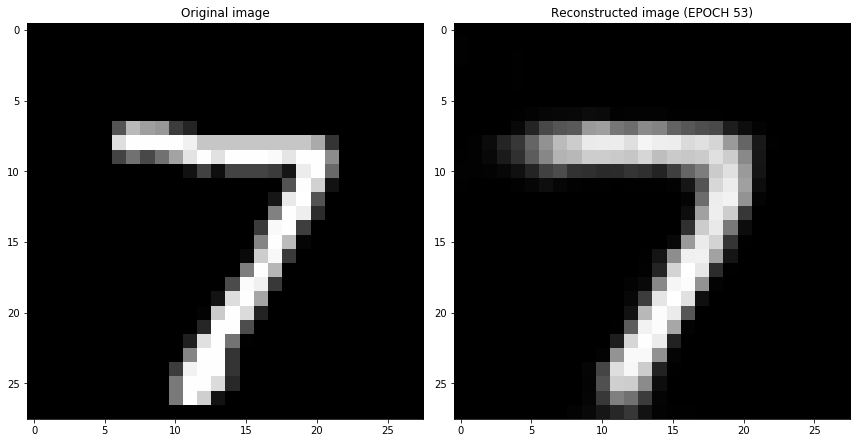

<Figure size 432x288 with 0 Axes>

EPOCH 54/100

	 TRAINING - EPOCH 54/100 - loss: 0.027578

	 VALIDATION - EPOCH 54/100 - loss: 0.027700




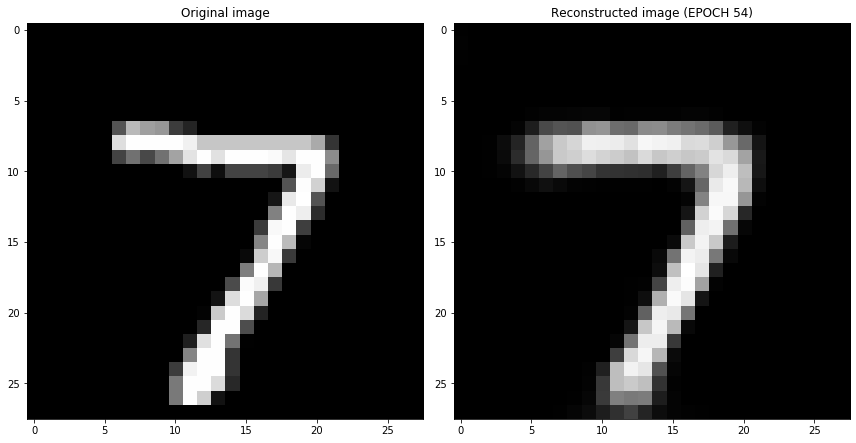

<Figure size 432x288 with 0 Axes>

EPOCH 55/100

	 TRAINING - EPOCH 55/100 - loss: 0.027623

	 VALIDATION - EPOCH 55/100 - loss: 0.027709




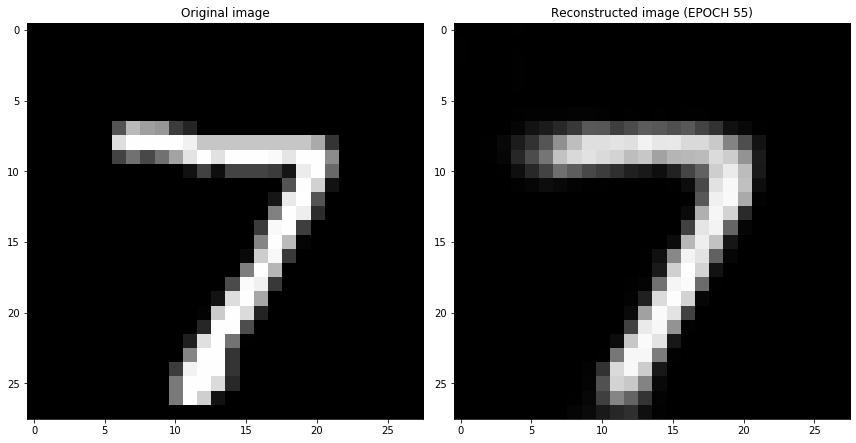

<Figure size 432x288 with 0 Axes>

EPOCH 56/100

	 TRAINING - EPOCH 56/100 - loss: 0.027504

	 VALIDATION - EPOCH 56/100 - loss: 0.027831




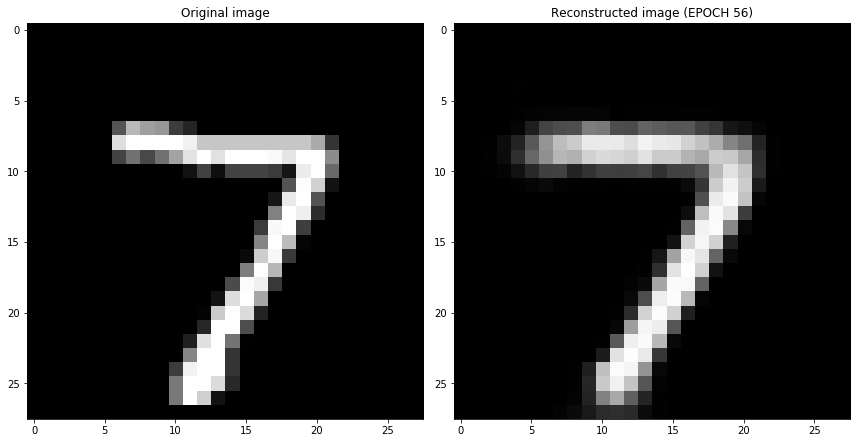

<Figure size 432x288 with 0 Axes>

EPOCH 57/100

	 TRAINING - EPOCH 57/100 - loss: 0.027930

	 VALIDATION - EPOCH 57/100 - loss: 0.028003




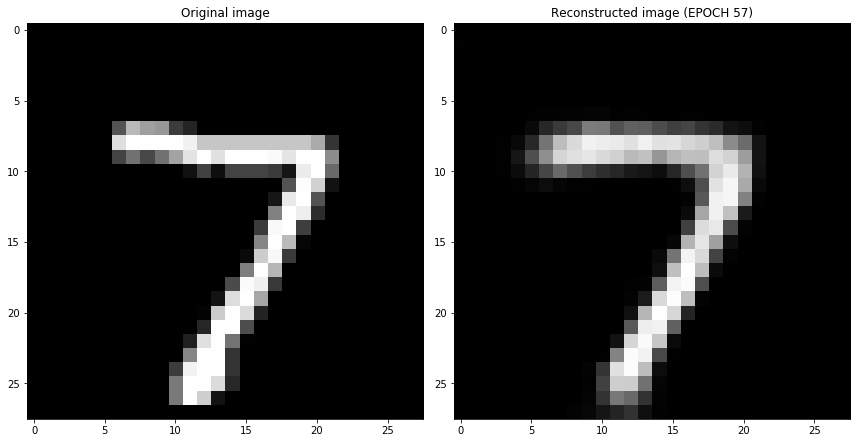

<Figure size 432x288 with 0 Axes>

EPOCH 58/100

	 TRAINING - EPOCH 58/100 - loss: 0.027754

	 VALIDATION - EPOCH 58/100 - loss: 0.028111




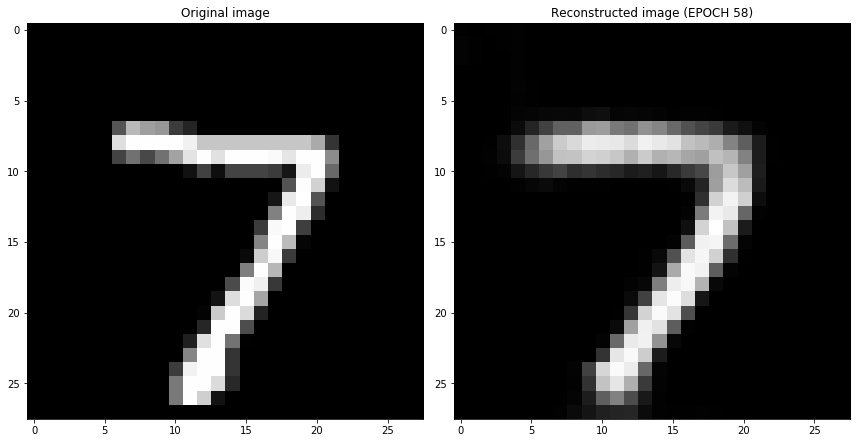

<Figure size 432x288 with 0 Axes>

EPOCH 59/100

	 TRAINING - EPOCH 59/100 - loss: 0.027541

	 VALIDATION - EPOCH 59/100 - loss: 0.027594




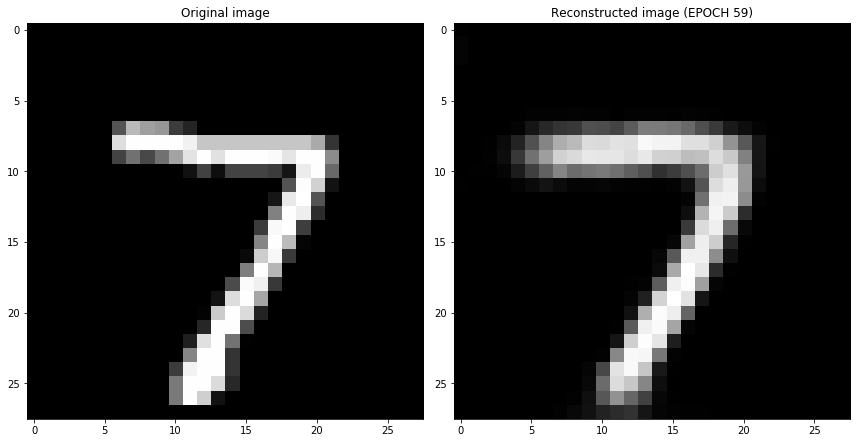

<Figure size 432x288 with 0 Axes>

EPOCH 60/100

	 TRAINING - EPOCH 60/100 - loss: 0.027699

	 VALIDATION - EPOCH 60/100 - loss: 0.027841




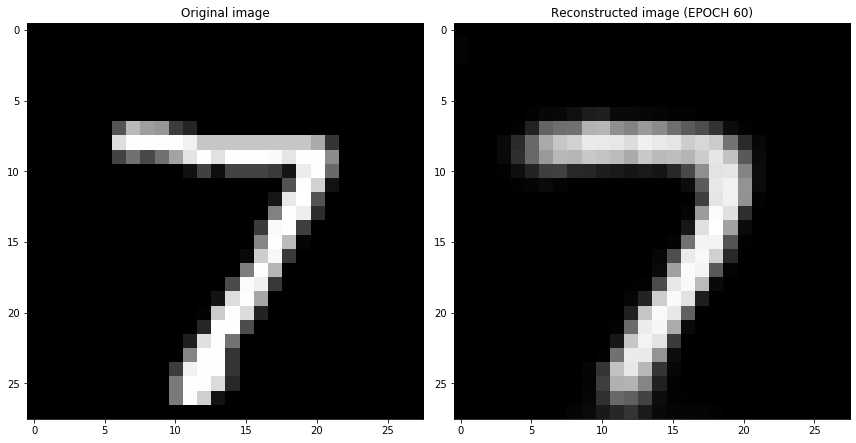

<Figure size 432x288 with 0 Axes>

EPOCH 61/100

	 TRAINING - EPOCH 61/100 - loss: 0.027373

	 VALIDATION - EPOCH 61/100 - loss: 0.027519




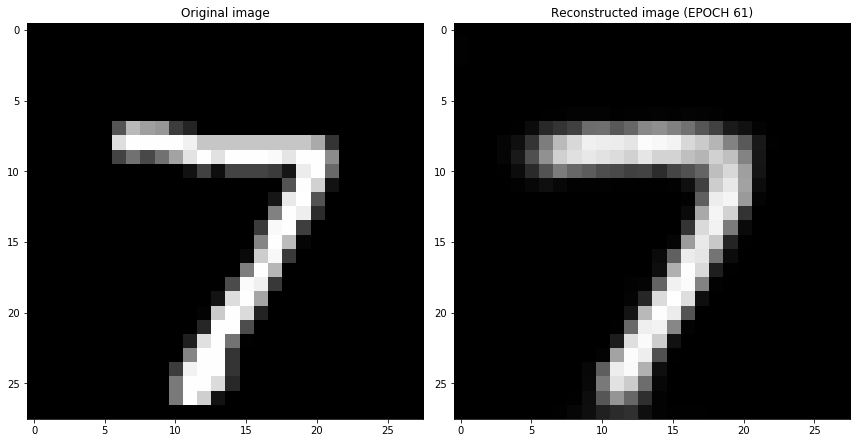

<Figure size 432x288 with 0 Axes>

EPOCH 62/100

	 TRAINING - EPOCH 62/100 - loss: 0.027321

	 VALIDATION - EPOCH 62/100 - loss: 0.027444




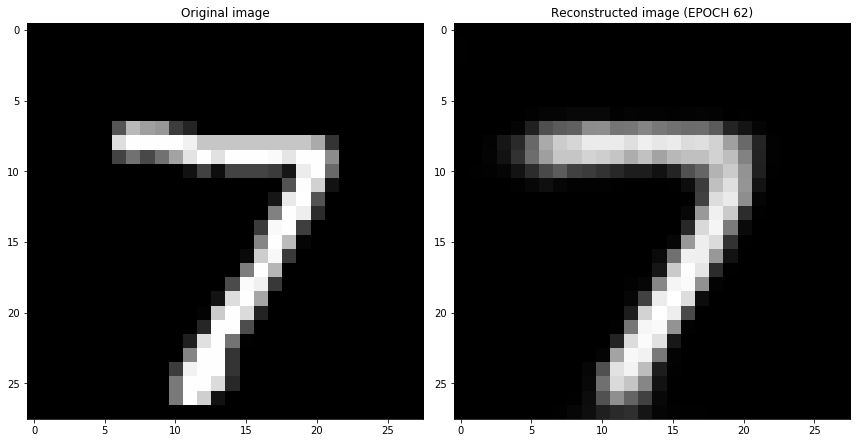

<Figure size 432x288 with 0 Axes>

EPOCH 63/100

	 TRAINING - EPOCH 63/100 - loss: 0.027491

	 VALIDATION - EPOCH 63/100 - loss: 0.027532




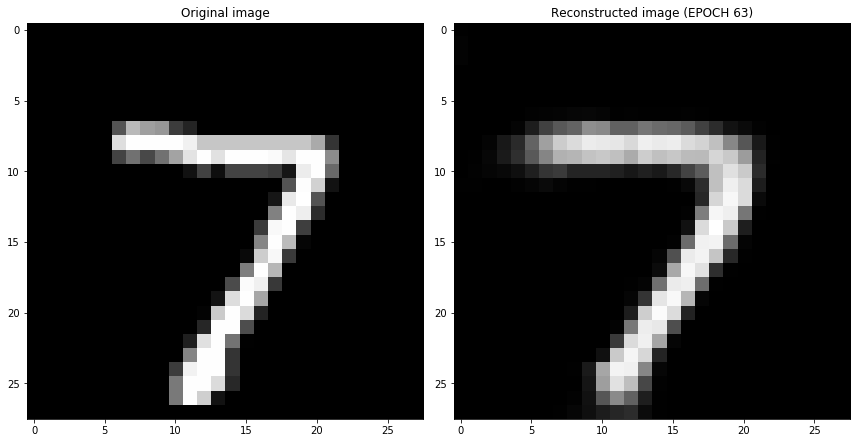

<Figure size 432x288 with 0 Axes>

EPOCH 64/100

	 TRAINING - EPOCH 64/100 - loss: 0.027449

	 VALIDATION - EPOCH 64/100 - loss: 0.027597




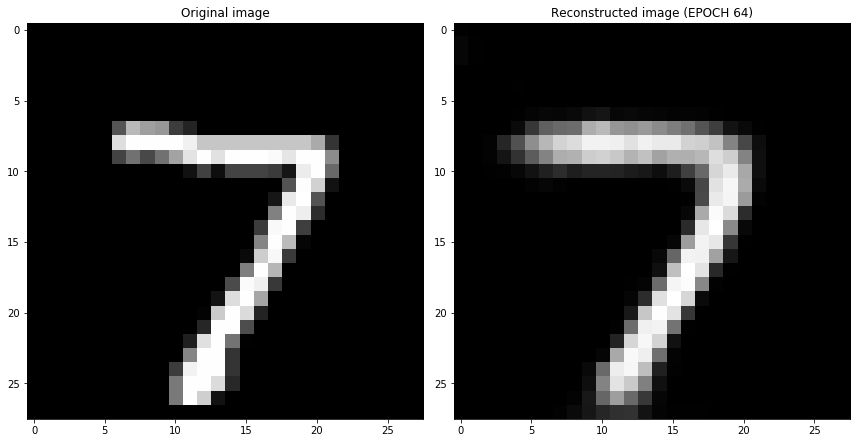

<Figure size 432x288 with 0 Axes>

EPOCH 65/100

	 TRAINING - EPOCH 65/100 - loss: 0.027349

	 VALIDATION - EPOCH 65/100 - loss: 0.027570




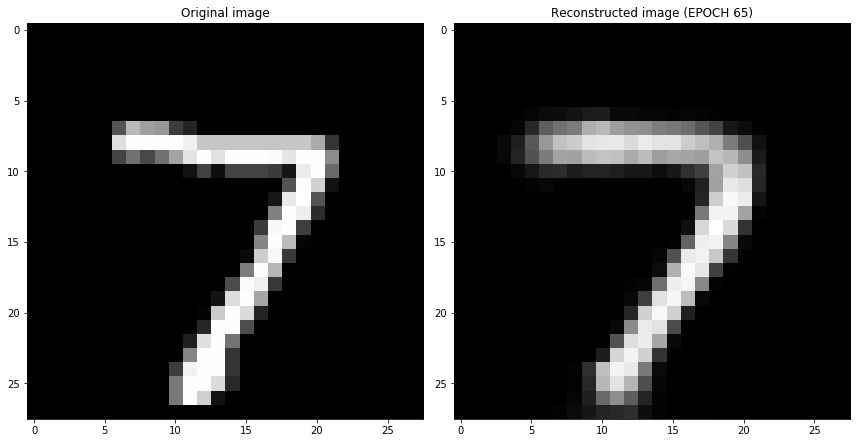

<Figure size 432x288 with 0 Axes>

EPOCH 66/100

	 TRAINING - EPOCH 66/100 - loss: 0.027775

	 VALIDATION - EPOCH 66/100 - loss: 0.027432




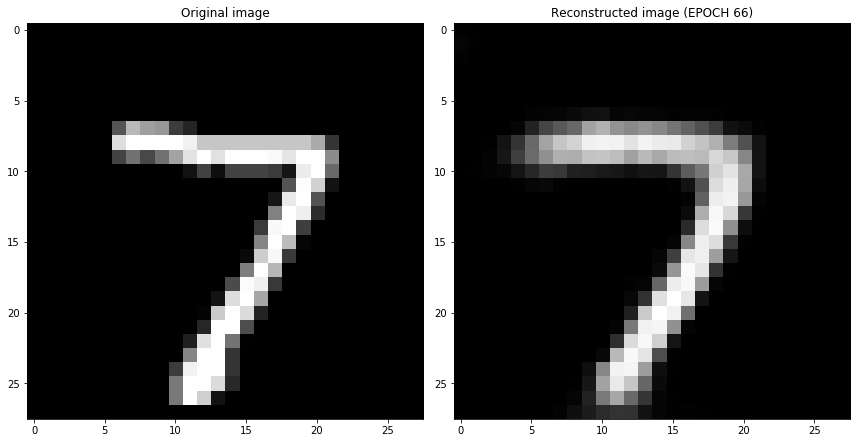

<Figure size 432x288 with 0 Axes>

EPOCH 67/100

	 TRAINING - EPOCH 67/100 - loss: 0.027264

	 VALIDATION - EPOCH 67/100 - loss: 0.027531




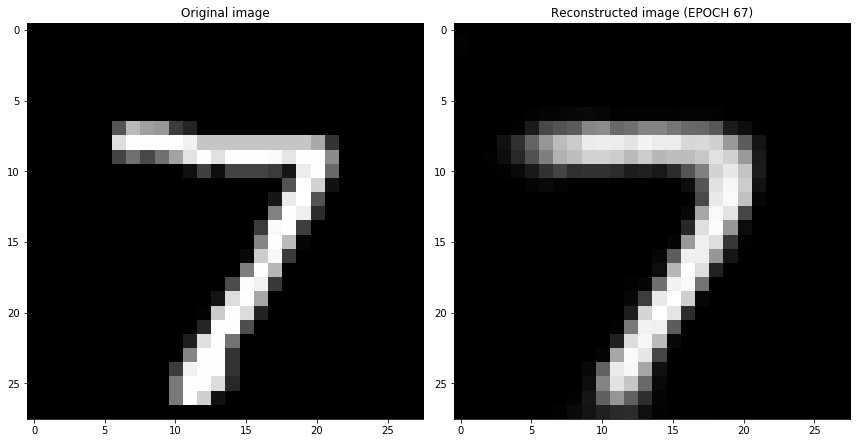

<Figure size 432x288 with 0 Axes>

EPOCH 68/100

	 TRAINING - EPOCH 68/100 - loss: 0.027318

	 VALIDATION - EPOCH 68/100 - loss: 0.027461




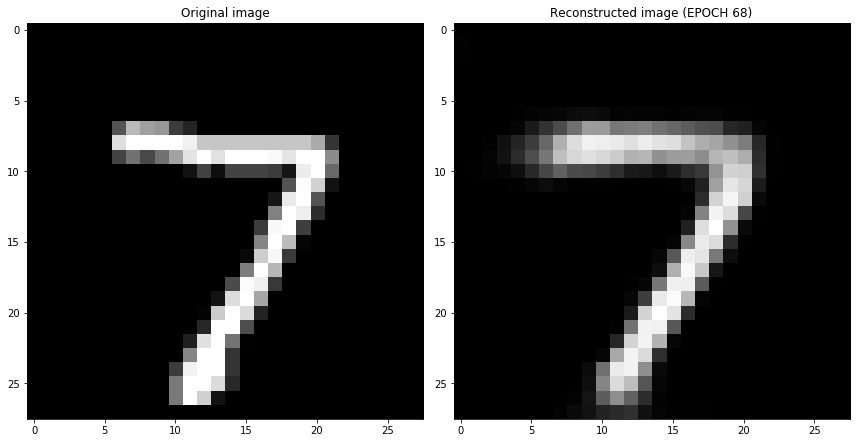

<Figure size 432x288 with 0 Axes>

EPOCH 69/100

	 TRAINING - EPOCH 69/100 - loss: 0.027330

	 VALIDATION - EPOCH 69/100 - loss: 0.027295




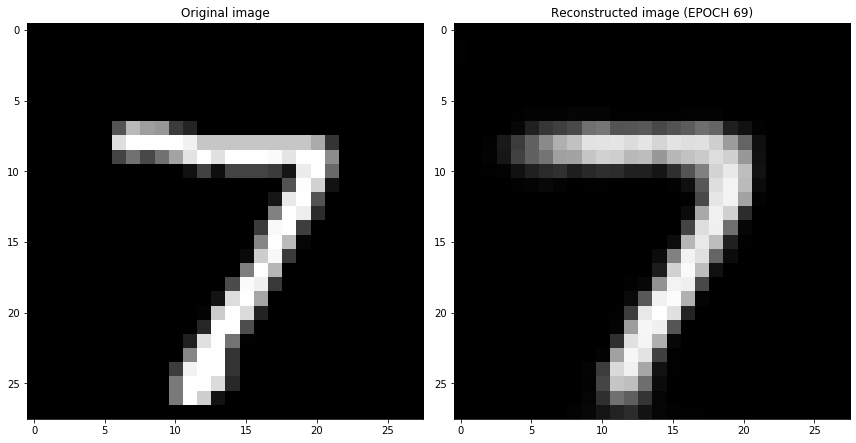

<Figure size 432x288 with 0 Axes>

EPOCH 70/100

	 TRAINING - EPOCH 70/100 - loss: 0.027208

	 VALIDATION - EPOCH 70/100 - loss: 0.027493




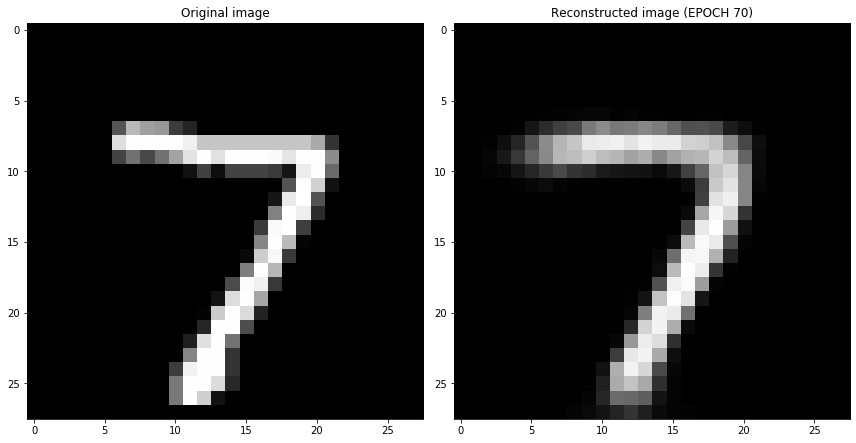

<Figure size 432x288 with 0 Axes>

EPOCH 71/100

	 TRAINING - EPOCH 71/100 - loss: 0.027345

	 VALIDATION - EPOCH 71/100 - loss: 0.027269




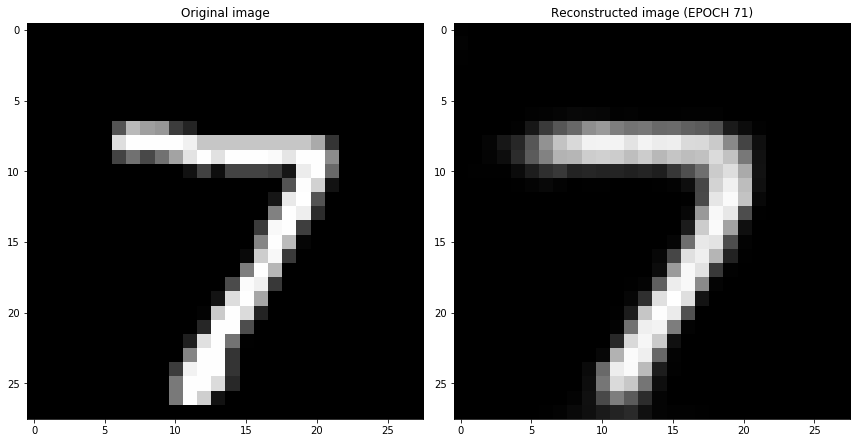

<Figure size 432x288 with 0 Axes>

EPOCH 72/100

	 TRAINING - EPOCH 72/100 - loss: 0.027262

	 VALIDATION - EPOCH 72/100 - loss: 0.027333




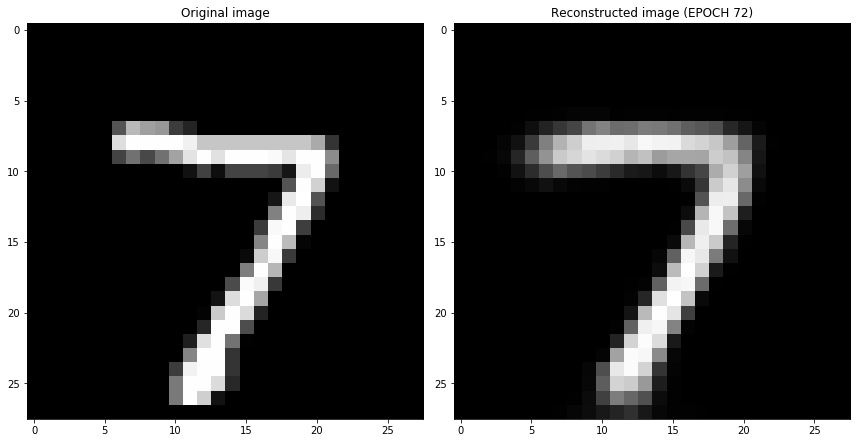

<Figure size 432x288 with 0 Axes>

EPOCH 73/100

	 TRAINING - EPOCH 73/100 - loss: 0.027379

	 VALIDATION - EPOCH 73/100 - loss: 0.027559




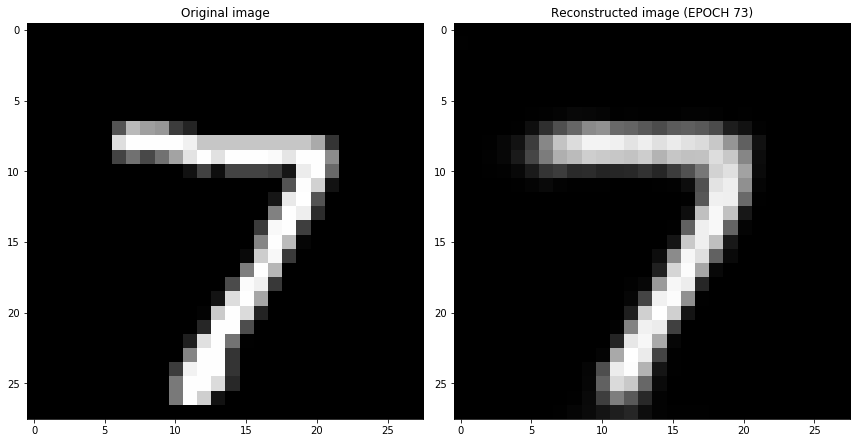

<Figure size 432x288 with 0 Axes>

EPOCH 74/100

	 TRAINING - EPOCH 74/100 - loss: 0.027339

	 VALIDATION - EPOCH 74/100 - loss: 0.027686




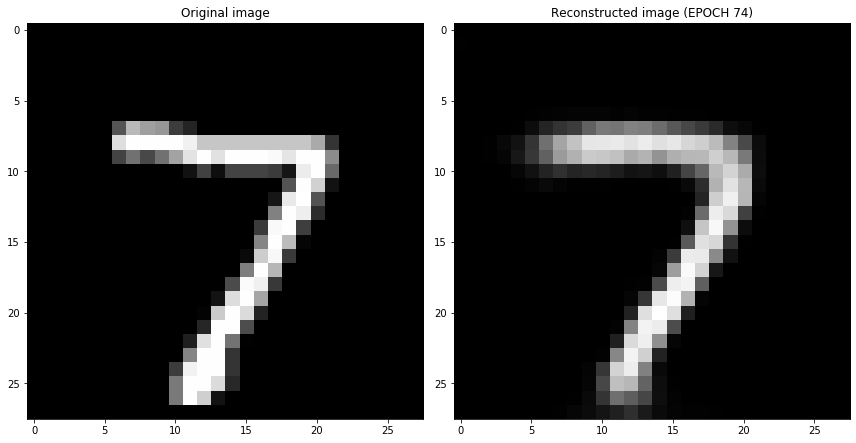

<Figure size 432x288 with 0 Axes>

EPOCH 75/100

	 TRAINING - EPOCH 75/100 - loss: 0.027245

	 VALIDATION - EPOCH 75/100 - loss: 0.027236




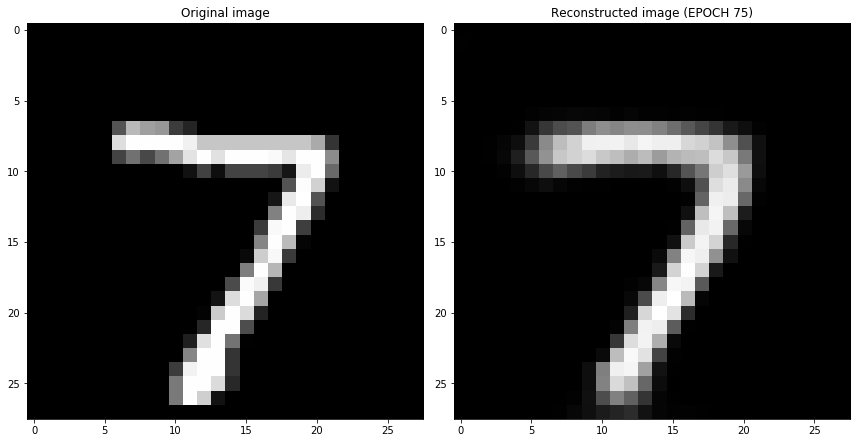

<Figure size 432x288 with 0 Axes>

EPOCH 76/100

	 TRAINING - EPOCH 76/100 - loss: 0.027053

	 VALIDATION - EPOCH 76/100 - loss: 0.027233




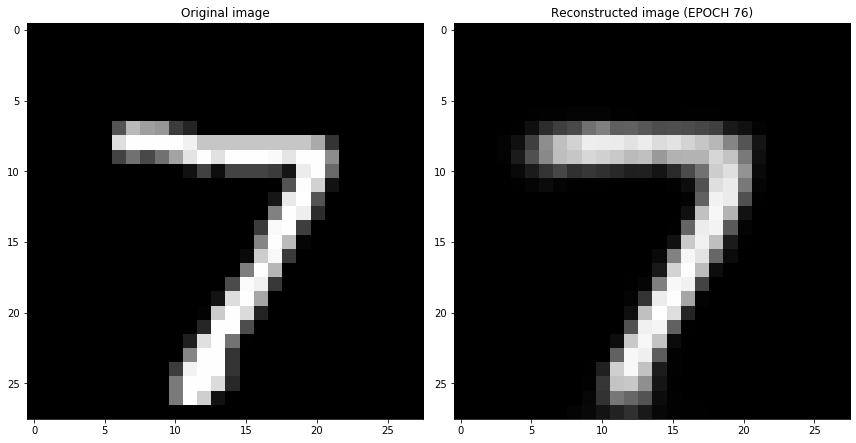

<Figure size 432x288 with 0 Axes>

EPOCH 77/100

	 TRAINING - EPOCH 77/100 - loss: 0.027229

	 VALIDATION - EPOCH 77/100 - loss: 0.027380




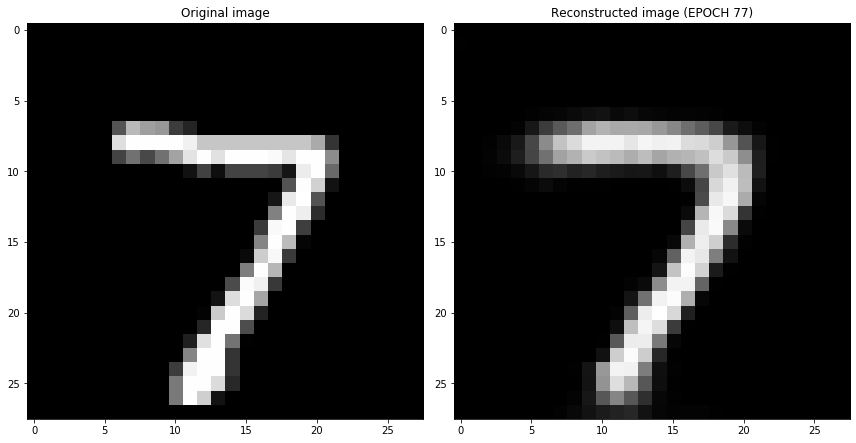

<Figure size 432x288 with 0 Axes>

EPOCH 78/100

	 TRAINING - EPOCH 78/100 - loss: 0.027130

	 VALIDATION - EPOCH 78/100 - loss: 0.027280




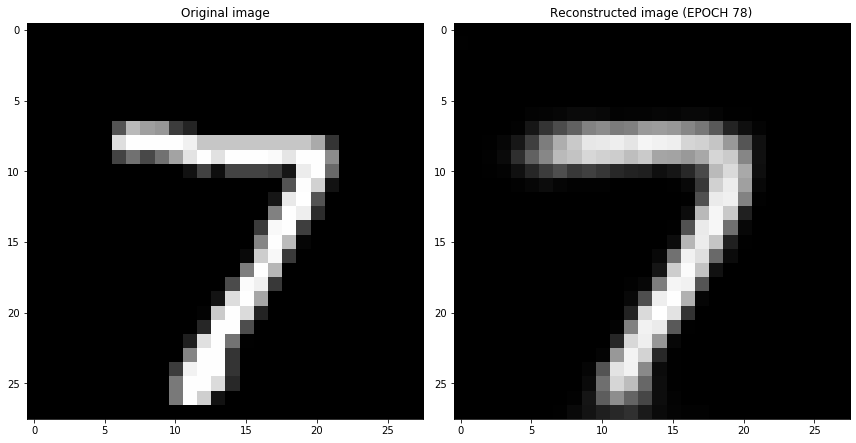

<Figure size 432x288 with 0 Axes>

EPOCH 79/100

	 TRAINING - EPOCH 79/100 - loss: 0.027107

	 VALIDATION - EPOCH 79/100 - loss: 0.027267




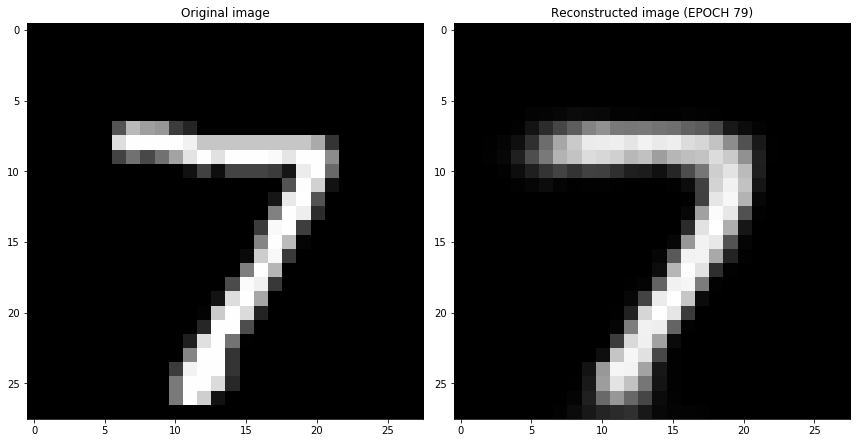

<Figure size 432x288 with 0 Axes>

EPOCH 80/100

	 TRAINING - EPOCH 80/100 - loss: 0.027700

	 VALIDATION - EPOCH 80/100 - loss: 0.027345




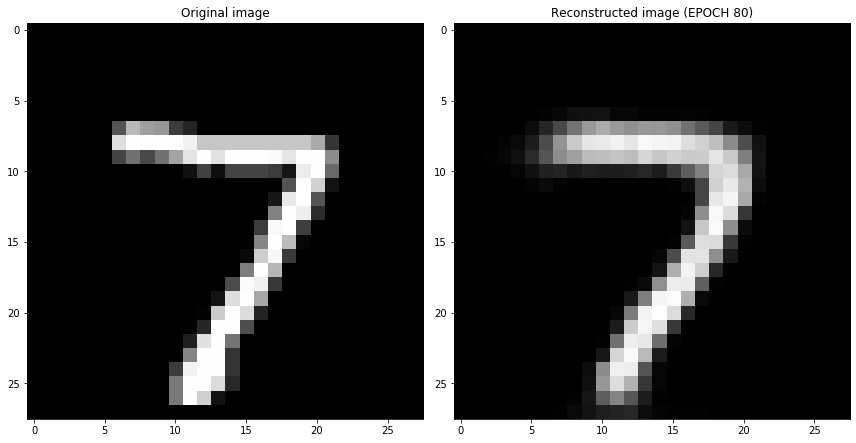

<Figure size 432x288 with 0 Axes>

EPOCH 81/100

	 TRAINING - EPOCH 81/100 - loss: 0.027041

	 VALIDATION - EPOCH 81/100 - loss: 0.027253




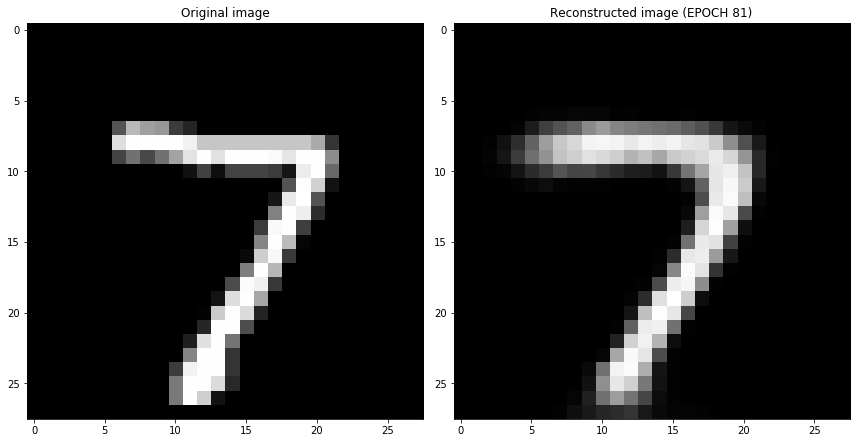

<Figure size 432x288 with 0 Axes>

EPOCH 82/100

	 TRAINING - EPOCH 82/100 - loss: 0.027254

	 VALIDATION - EPOCH 82/100 - loss: 0.027215




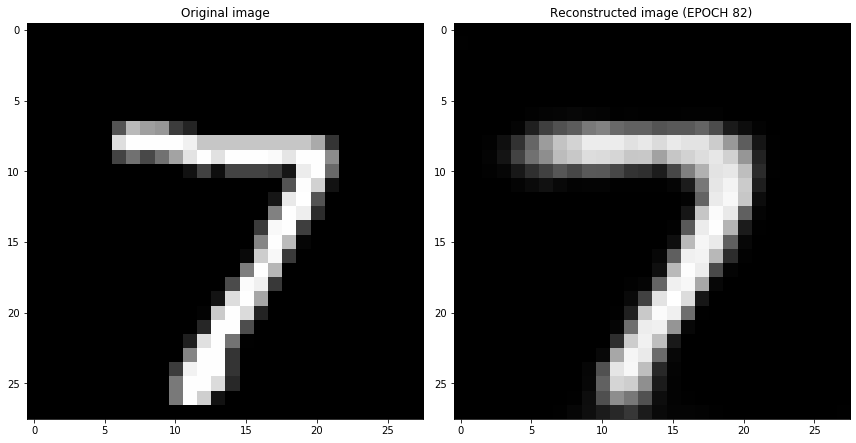

<Figure size 432x288 with 0 Axes>

EPOCH 83/100

	 TRAINING - EPOCH 83/100 - loss: 0.027001

	 VALIDATION - EPOCH 83/100 - loss: 0.027311




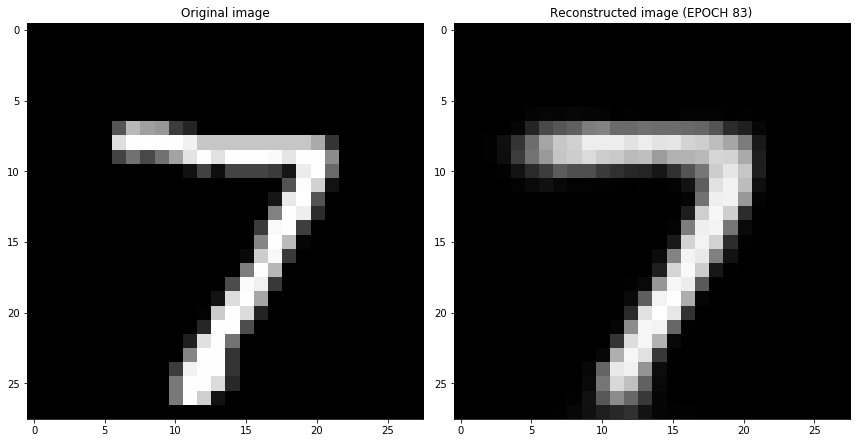

<Figure size 432x288 with 0 Axes>

EPOCH 84/100

	 TRAINING - EPOCH 84/100 - loss: 0.027067

	 VALIDATION - EPOCH 84/100 - loss: 0.027291




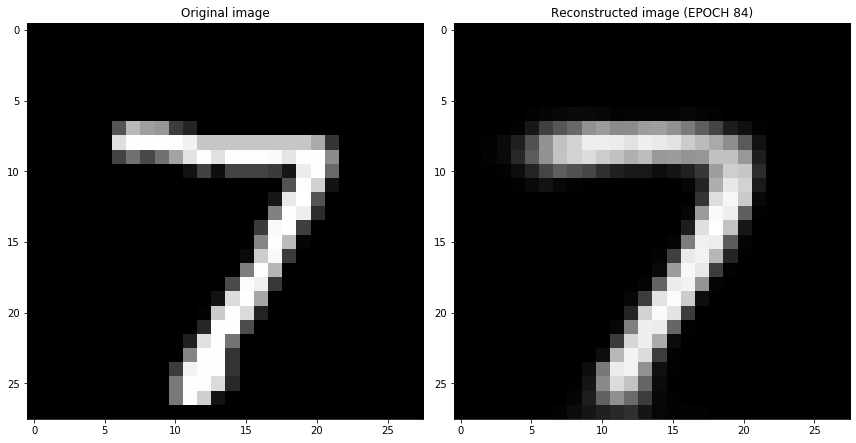

<Figure size 432x288 with 0 Axes>

EPOCH 85/100

	 TRAINING - EPOCH 85/100 - loss: 0.027039

	 VALIDATION - EPOCH 85/100 - loss: 0.027298




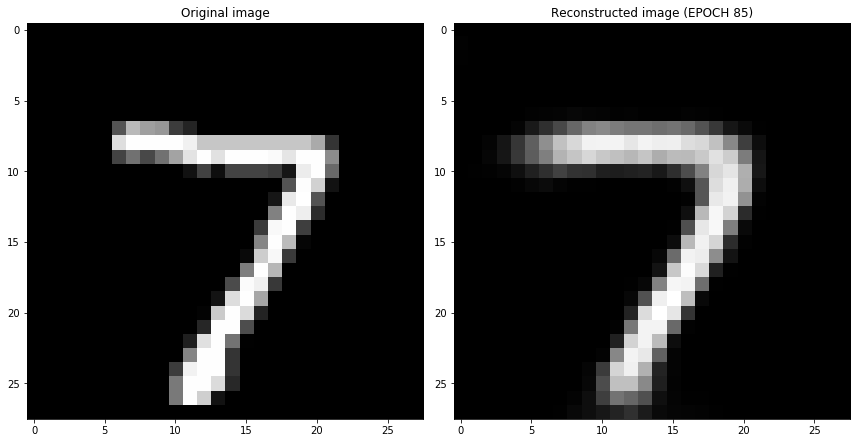

<Figure size 432x288 with 0 Axes>

EPOCH 86/100

	 TRAINING - EPOCH 86/100 - loss: 0.027082

	 VALIDATION - EPOCH 86/100 - loss: 0.027157




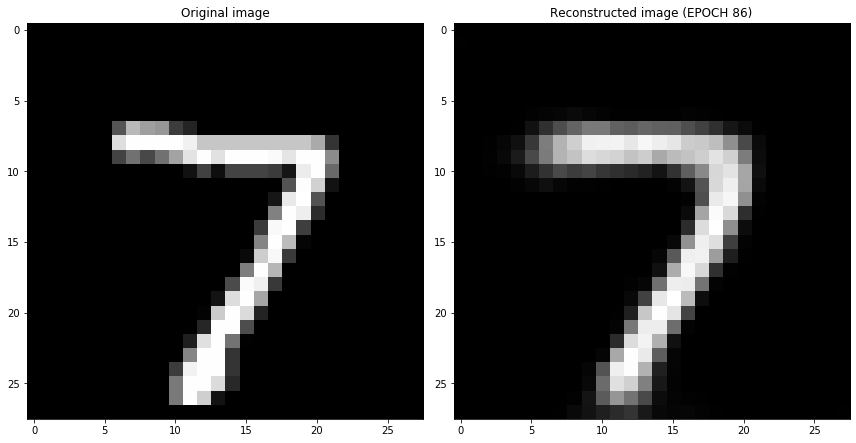

<Figure size 432x288 with 0 Axes>

EPOCH 87/100

	 TRAINING - EPOCH 87/100 - loss: 0.027039

	 VALIDATION - EPOCH 87/100 - loss: 0.027250




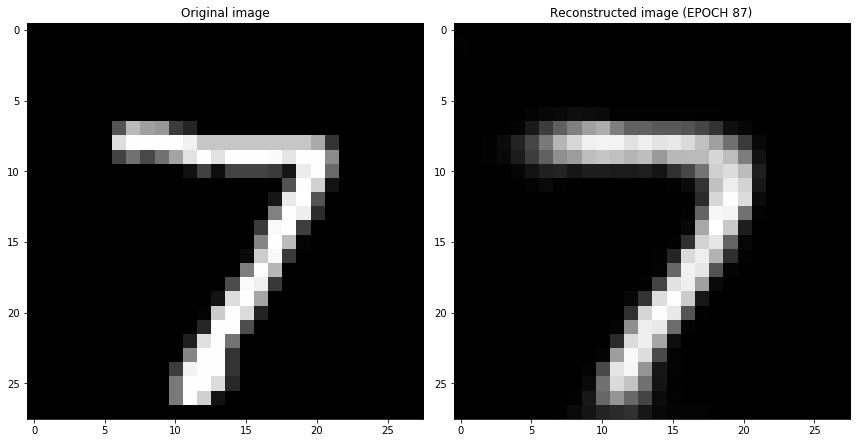

<Figure size 432x288 with 0 Axes>

EPOCH 88/100

	 TRAINING - EPOCH 88/100 - loss: 0.027085

	 VALIDATION - EPOCH 88/100 - loss: 0.027667




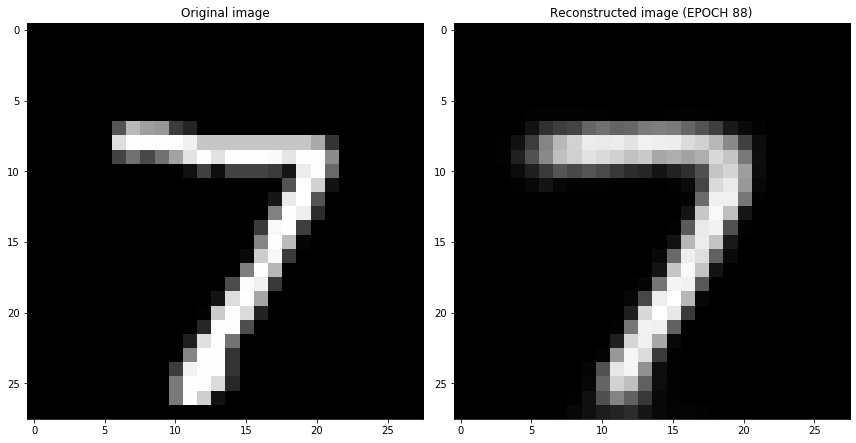

<Figure size 432x288 with 0 Axes>

EPOCH 89/100

	 TRAINING - EPOCH 89/100 - loss: 0.027079

	 VALIDATION - EPOCH 89/100 - loss: 0.027483




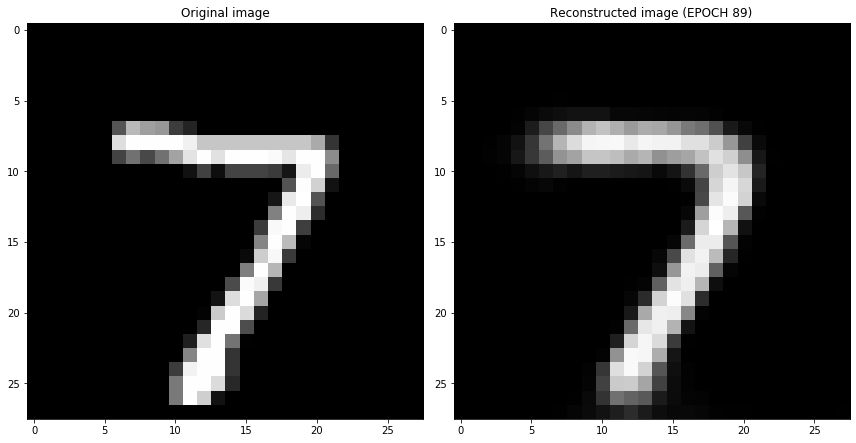

<Figure size 432x288 with 0 Axes>

EPOCH 90/100

	 TRAINING - EPOCH 90/100 - loss: 0.027027

	 VALIDATION - EPOCH 90/100 - loss: 0.027235




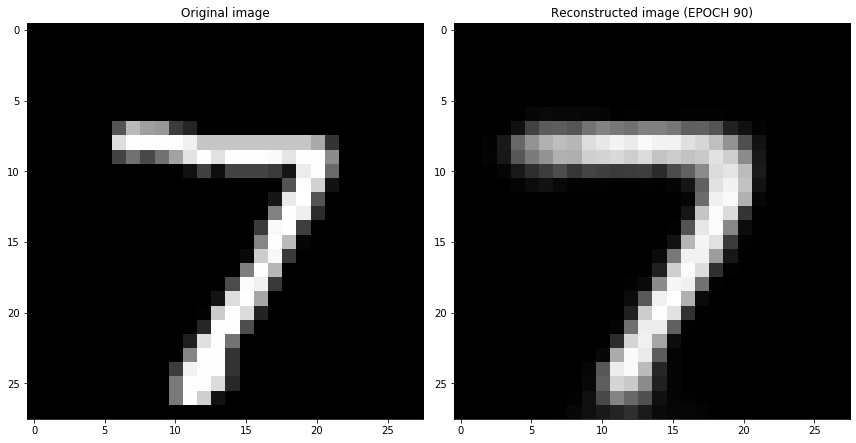

<Figure size 432x288 with 0 Axes>

EPOCH 91/100

	 TRAINING - EPOCH 91/100 - loss: 0.027102

	 VALIDATION - EPOCH 91/100 - loss: 0.027245




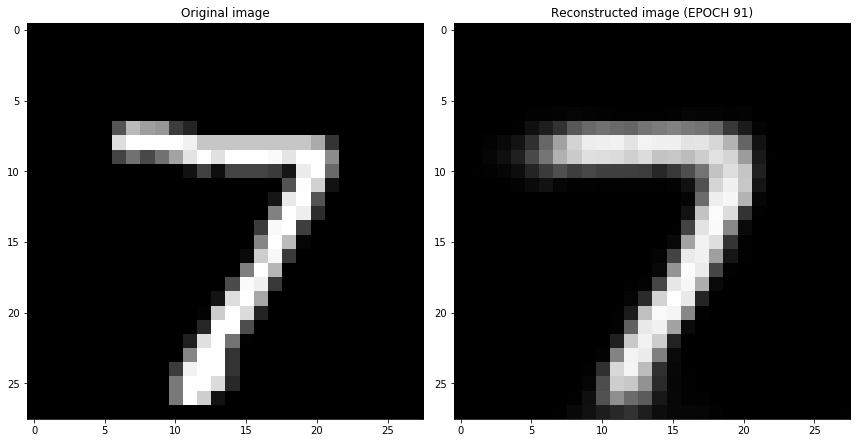

<Figure size 432x288 with 0 Axes>

EPOCH 92/100

	 TRAINING - EPOCH 92/100 - loss: 0.027184

	 VALIDATION - EPOCH 92/100 - loss: 0.028083




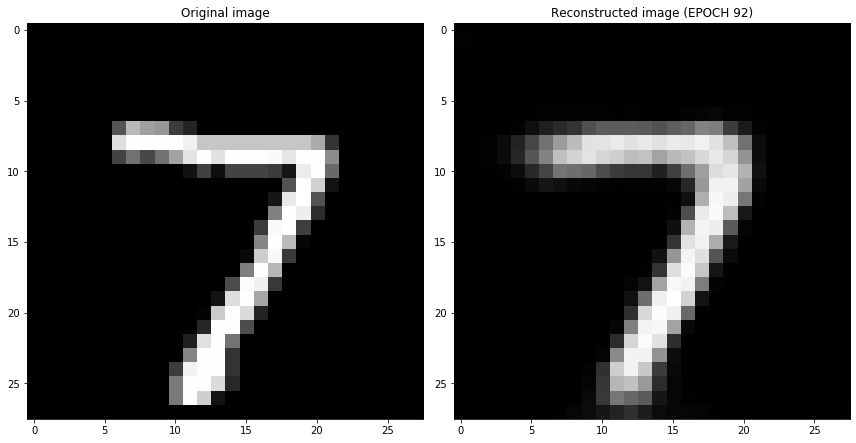

<Figure size 432x288 with 0 Axes>

EPOCH 93/100

	 TRAINING - EPOCH 93/100 - loss: 0.027094

	 VALIDATION - EPOCH 93/100 - loss: 0.027267




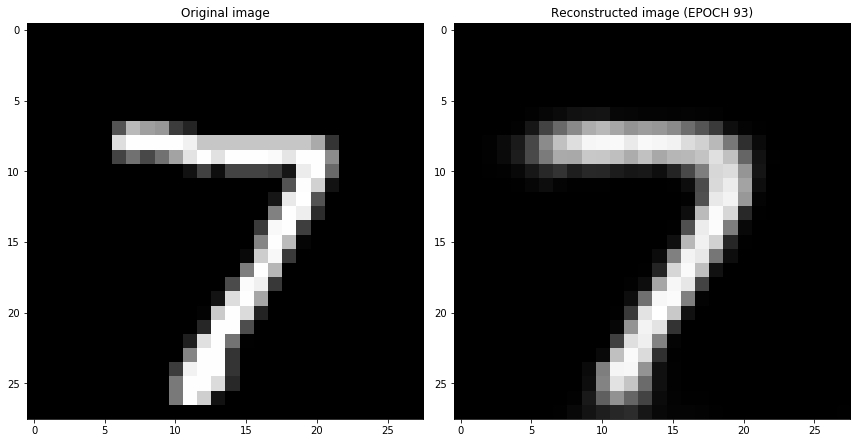

<Figure size 432x288 with 0 Axes>

EPOCH 94/100

	 TRAINING - EPOCH 94/100 - loss: 0.027054

	 VALIDATION - EPOCH 94/100 - loss: 0.027153




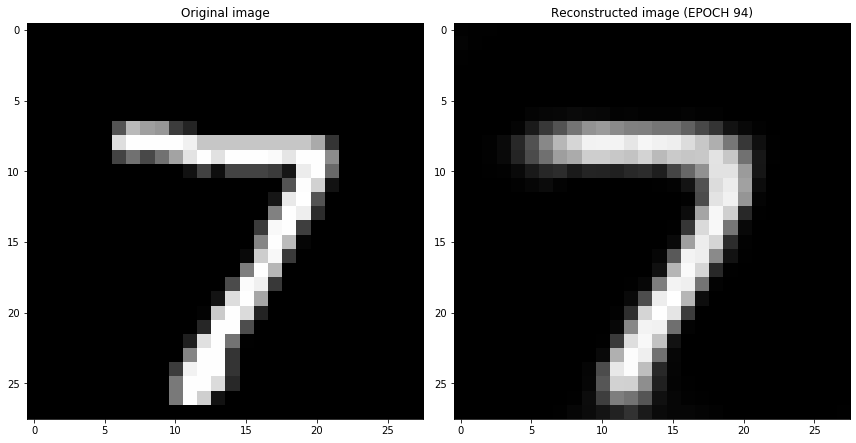

<Figure size 432x288 with 0 Axes>

EPOCH 95/100

	 TRAINING - EPOCH 95/100 - loss: 0.026856

	 VALIDATION - EPOCH 95/100 - loss: 0.026987




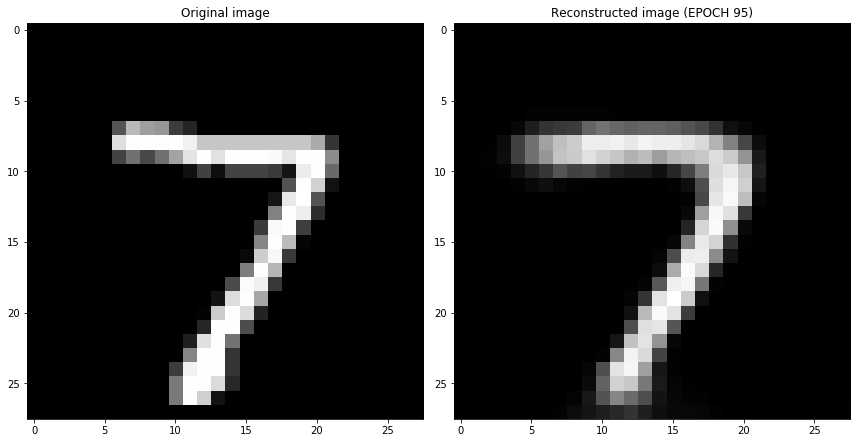

<Figure size 432x288 with 0 Axes>

EPOCH 96/100

	 TRAINING - EPOCH 96/100 - loss: 0.026919

	 VALIDATION - EPOCH 96/100 - loss: 0.027279




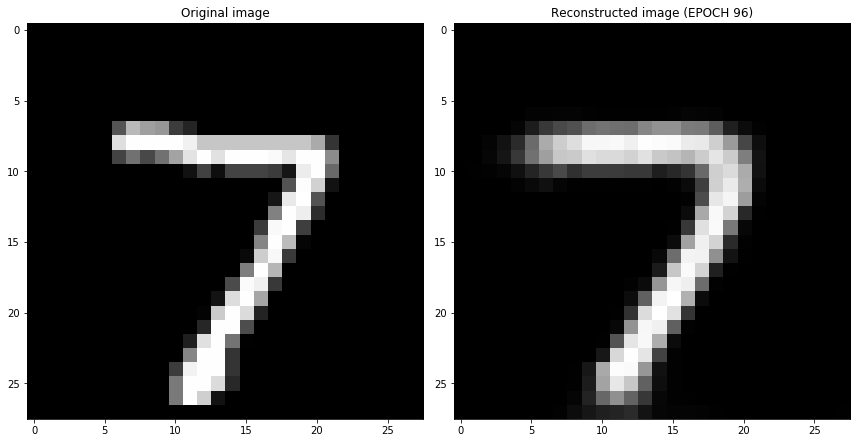

<Figure size 432x288 with 0 Axes>

EPOCH 97/100

	 TRAINING - EPOCH 97/100 - loss: 0.026993

	 VALIDATION - EPOCH 97/100 - loss: 0.027137




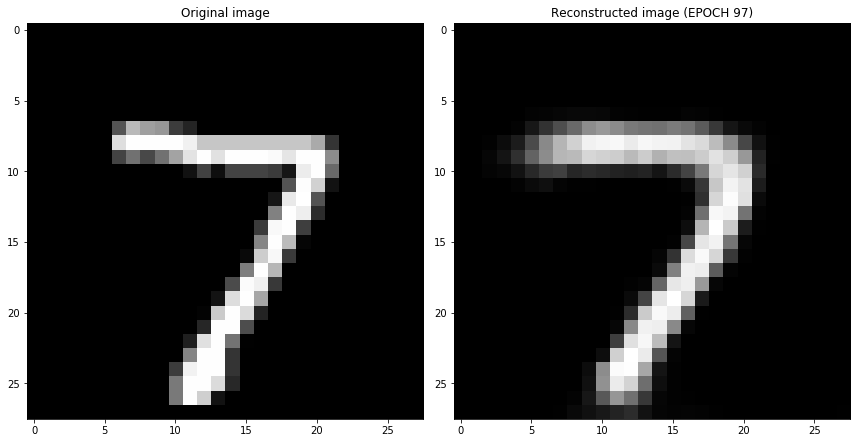

<Figure size 432x288 with 0 Axes>

EPOCH 98/100

	 TRAINING - EPOCH 98/100 - loss: 0.026982

	 VALIDATION - EPOCH 98/100 - loss: 0.026925




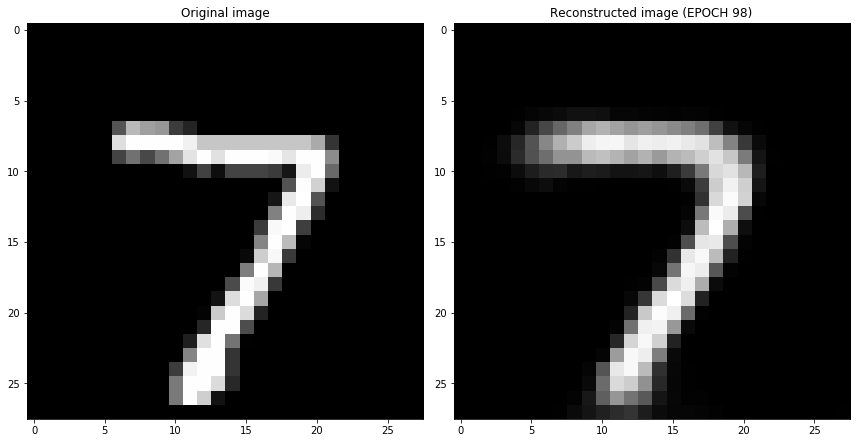

<Figure size 432x288 with 0 Axes>

EPOCH 99/100

	 TRAINING - EPOCH 99/100 - loss: 0.026975

	 VALIDATION - EPOCH 99/100 - loss: 0.027334




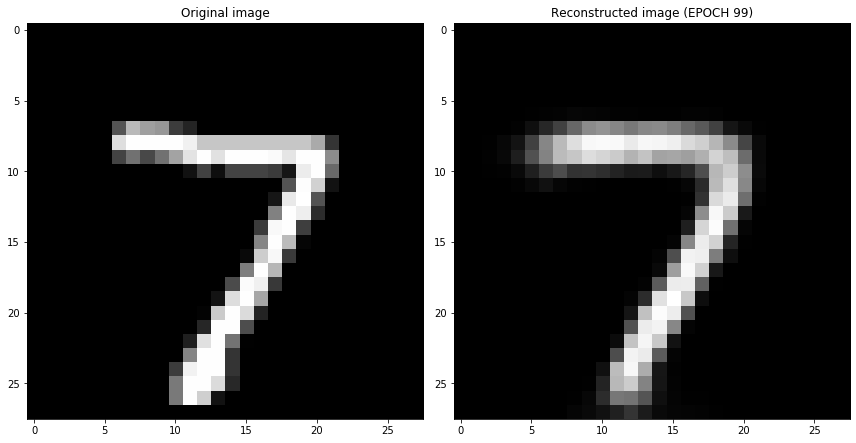

<Figure size 432x288 with 0 Axes>

EPOCH 100/100

	 TRAINING - EPOCH 100/100 - loss: 0.026859

	 VALIDATION - EPOCH 100/100 - loss: 0.026961




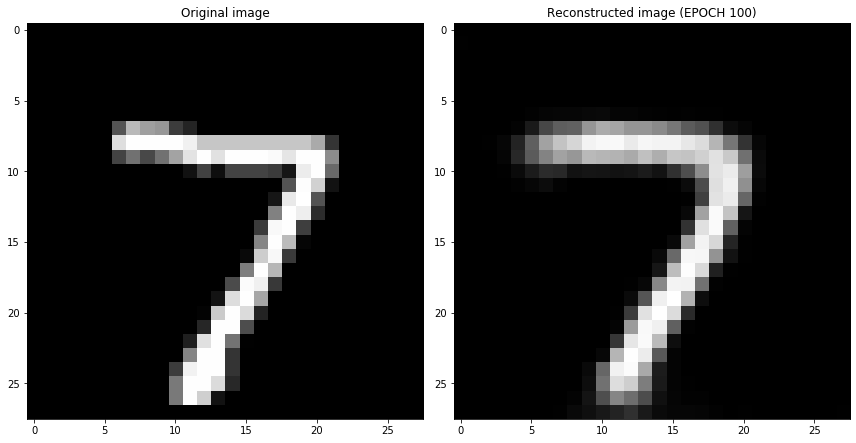

<Figure size 432x288 with 0 Axes>

CPU times: user 1h 52min 28s, sys: 22.2 s, total: 1h 52min 50s
Wall time: 1h 22min 34s


In [93]:
%%time

# Set dimension of interest
encoded_space_dim = 4
# Initialize the network
net = Autoencoder(encoded_space_dim=encoded_space_dim)


# Set number of epochs
num_epochs = 100
# Set learning parameters
lr = 1e-2
decay = 1e-5
# Define an optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=decay)

train_loss_log = []
val_loss_log = []

### Training cycle
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training
    train_loss = train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim, device=device) 
    print('\n\t TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))
    ### Validation
    val_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim, device=device) 
    # Print Validation
    print('\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    img = test_dataset[0][0].unsqueeze(0).to(device)
    net.eval()
    with torch.no_grad():
        rec_img  = net(img)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('./images/autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    plt.savefig('./images/autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(net.state_dict(), f'./results/net_params_{encoded_space_dim}.pth')

    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)
    
    # Early stopping
    if epoch>100 and abs(val_loss_log[-1] - val_loss_log[-100]) < 0.001:
        break

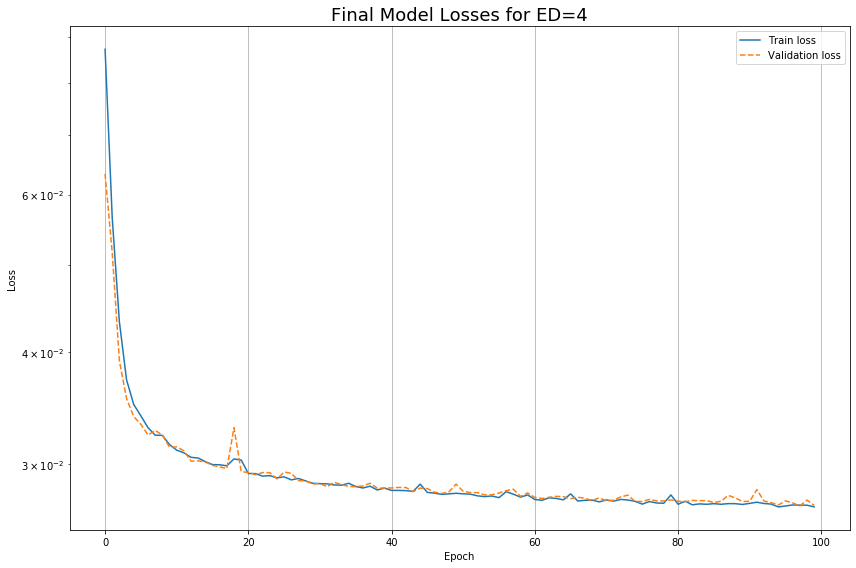

In [94]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_log, 
                label='Train loss')
plt.semilogy(val_loss_log, 
                label='Validation loss',
                linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title(f'Final Model Losses for ED={encoded_space_dim}', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(f"images/model_losses_{encoded_space_dim}.png")
plt.show()

# Test

In [9]:
### Set dimension of interest
encoded_space_dim = 4

### Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Initialize the network by loading
params = torch.load(f'./results/net_params_{encoded_space_dim}.pth', map_location = device)
# print(*params, sep='\n')
# print(*[p.shape for p in params.values()], sep='\n')
net = Autoencoder(encoded_space_dim = encoded_space_dim)
net.load_state_dict(params)
net.to(device)

### Define a loss function
loss_fn = torch.nn.MSELoss()
 
### Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Test on Standard Images

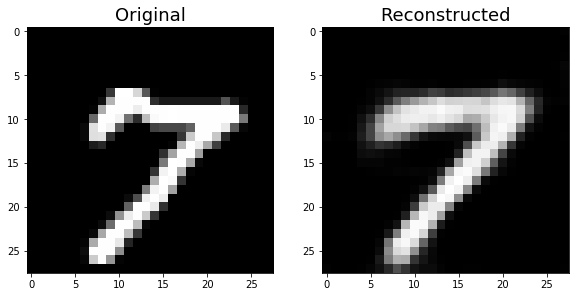

In [10]:
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # No need to track the gradients
    conc_out = torch.Tensor().float()
    conc_label = torch.Tensor().float()
    for sample_batch in test_dataloader:
        # Extract data and move tensors to the selected device
        image_batch = sample_batch[0].to(device)
        # Forward pass
        out = net(image_batch)
        # Concatenate with previous outputs
        conc_out = torch.cat([conc_out, out.cpu()])
        conc_label = torch.cat([conc_label, image_batch.cpu()]) 

    # plot images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original", fontsize=18)
    plt.imshow(image_batch[0].squeeze().cpu(), cmap='gist_gray')
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed", fontsize=18)
    plt.imshow(out[0].squeeze().cpu(), cmap='gist_gray')
    plt.savefig("images/Original_4.png")
    plt.show()


    # Evaluate global loss
    test_loss = loss_fn(conc_out, conc_label)
    test_loss

## Test on Randomly Corrupted Images 

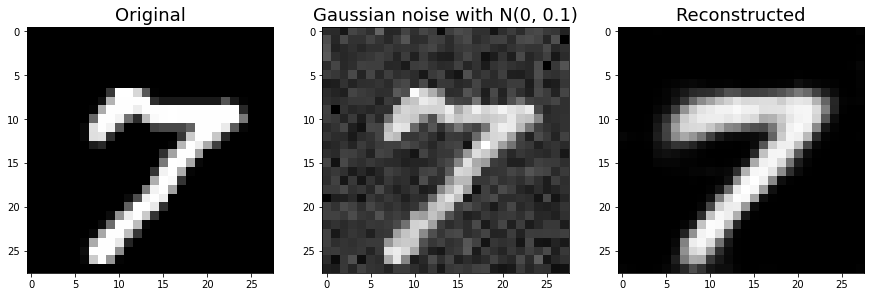

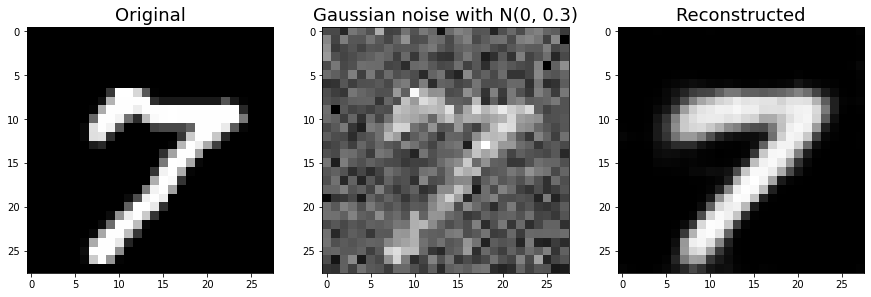

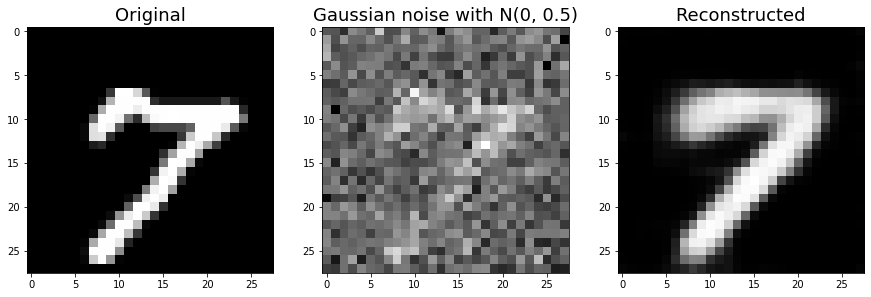

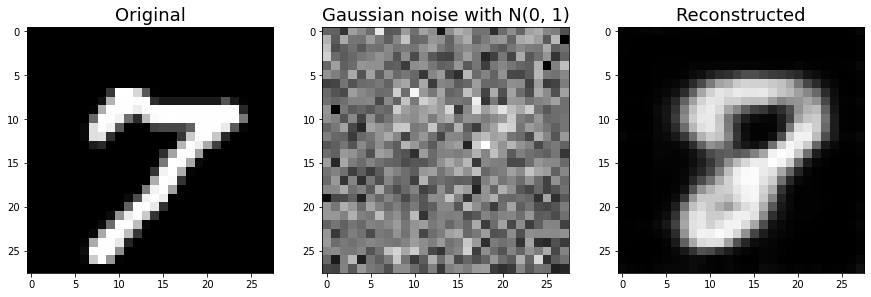

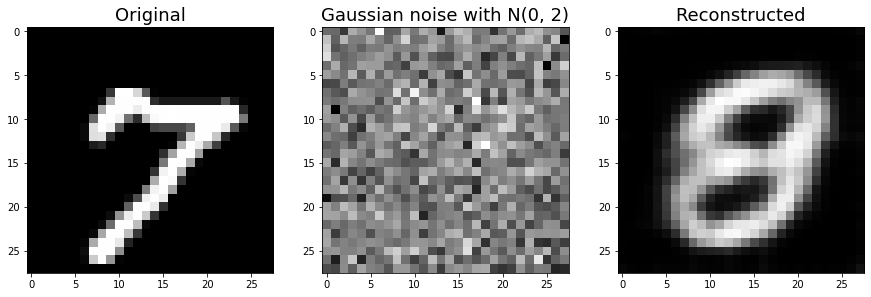

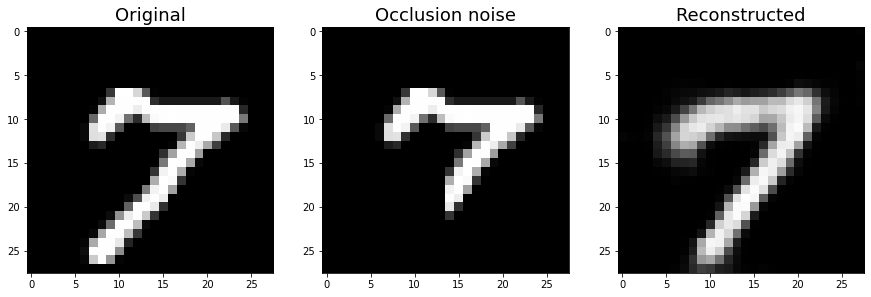

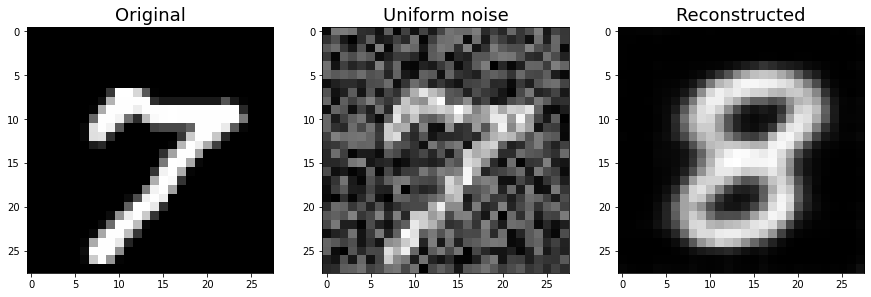

noise_type	error
N(0,0.1) 	  0.027442785
N(0,0.3) 	  0.032414775
N(0,0.5) 	  0.041436195
N(0,1) 	 	 0.062495653
N(0,2) 	 	 0.08463218
occlusion	 0.05018206
uniform		 0.09382705


In [11]:
sigma_list = [0.1, 0.3, 0.5, 1, 2]

# Gaussian noise
gauss_error=[]
for sigma in sigma_list:
    sigma_error = test_random_noise(net=net, dataloader=test_dataloader, 
                                    loss_fn=loss_fn,
                                    device=device,
                                    noise_type='Gaussian',
                                    sigma=sigma) 
    gauss_error.append(sigma_error)

# Occlusion noise
occlusion_error = test_random_noise(net=net, dataloader=test_dataloader, 
                                    loss_fn=loss_fn,
                                    device=device,
                                    noise_type='Occlusion') 


# Uniform error
uniform_error = test_random_noise(net=net, dataloader=test_dataloader, 
                                    loss_fn=loss_fn,
                                    device=device,
                                    noise_type='Uniform')

print("noise_type\terror")
for i,sigma in enumerate(sigma_list):
    add_tab=''
    if sigma in [1,2]: add_tab = '\t'
    print(f"N(0,{sigma})","\t",add_tab,gauss_error[i].numpy())
print("occlusion\t",occlusion_error.numpy())
print("uniform\t\t",uniform_error.numpy())

In [ ]:
'''
### dim=4 ###
noise_type	error
N(0,0.1) 	  0.027442785
N(0,0.3) 	  0.032414775
N(0,0.5) 	  0.041436195
N(0,1) 	 	 0.062495653
N(0,2) 	 	 0.08463218
occlusion	 0.05018206
uniform		 0.09382705

### dim=32 ###
noise_type	error
N(0,0.1) 	  0.00962089
N(0,0.3) 	  0.021008287
N(0,0.5) 	  0.037717797
N(0,1) 	 	 0.07703511
N(0,2) 	 	 0.13436298
occlusion	 0.032860734
uniform		 0.18368684

'''

## Check on the MNIST.mat dataset

In [12]:
!python trained_model.py

the MSE is: 0.019417142495512962


# Latent space analysis

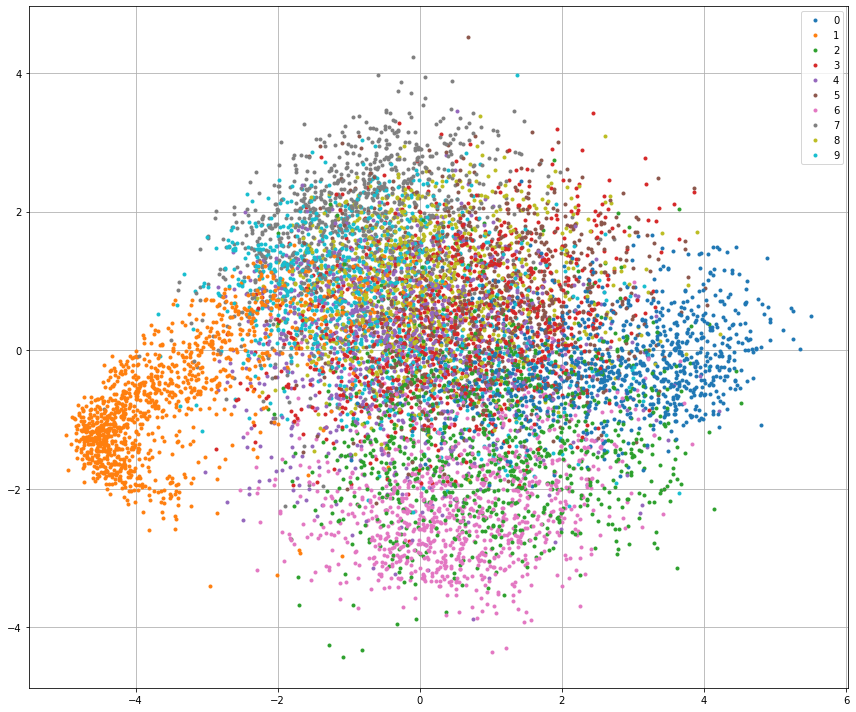

In [37]:
#%% Network analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


### Set dimension of interest
encoded_space_dim = 16

### Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Initialize the network by loading
params = torch.load(f'./results/net_params_{encoded_space_dim}.pth', map_location = device)
# print(*params, sep='\n')
# print(*[p.shape for p in params.values()], sep='\n')
net = Autoencoder(encoded_space_dim = encoded_space_dim)
net.load_state_dict(params)
net.to(device)

### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    net.eval()
    with torch.no_grad():
        encoded_img  = net.encode(img)
    # Append to list
    encoded_samples.append((encoded_img.flatten().numpy(), label))
    

### Visualize encoded space
color_map = {
        0: '#1f77b4',
        1: '#ff7f0e',
        2: '#2ca02c',
        3: '#d62728',
        4: '#9467bd',
        5: '#8c564b',
        6: '#e377c2',
        7: '#7f7f7f',
        8: '#bcbd22',
        9: '#17becf'
        }
    
# Plot just 1k points
# encoded_samples_reduced = random.sample(encoded_samples, 1000)
encoded_samples_reduced = encoded_samples

# PCA extraction
encoded_matrix = np.array(encoded_samples_reduced)
encoding = encoded_matrix[:,0]
label = encoded_matrix[:,1]
# Reshape data
for i, enc in enumerate(encoding):
    encoding[i] = enc.reshape((encoded_space_dim))
encoding[0]
# Standardise data
encoding_standard = StandardScaler().fit_transform(list(encoding))
# PCA - 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(encoding_standard)
principal = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])
principal['label'] = label

# PLOT
plt.figure(figsize=(12,10))
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('Latent space with PCA', fontsize = 20)

for row in tqdm(principal.values):
    pc1, pc2, label = row
    plt.plot(pc1, pc2, marker='.', color=color_map[label])
    
plt.grid(True)
plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], 
           color_map.keys())
plt.tight_layout()
plt.savefig(f"images/encoded_space_{encoded_space_dim}.png")
plt.show()